In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import covasim as cv
from util import data

sns.set_context('notebook')
sns.set_style('whitegrid')

pop_region = 4.46e6
pop_size = 450e3
pop_scale = 10

cols = ['n_severe', 'n_critical', 'cum_deaths']
n_runs = 3
n_trials = 1000

Covasim 2.0.2 (2020-02-01) — © 2021 by IDM


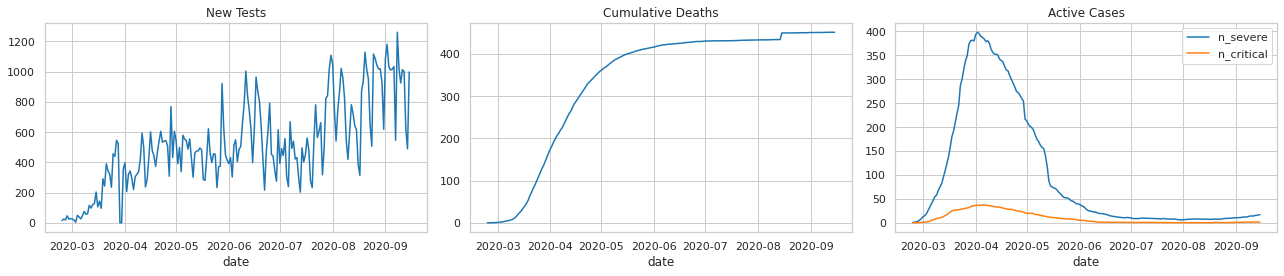

In [2]:
df = data.get_regional_data(scaling_factor=pop_region/pop_size)
df = df[df['date'] <= pd.to_datetime('2020-09-15')]

_, axes = plt.subplots(1, 3, figsize=(18, 4), sharey=False)

sns.lineplot(data=df, x='date', y='new_tests', ax=axes[0]).set(title='New Tests', ylabel='')
sns.lineplot(data=df, x='date', y='cum_deaths', ax=axes[1]).set(title='Cumulative Deaths', ylabel='')
sns.lineplot(data=df, x='date', y='n_severe', label='n_severe', ax=axes[2]).set(title='Active Cases')
sns.lineplot(data=df, x='date', y='n_critical', label='n_critical', ax=axes[2]).set(ylabel='')

plt.tight_layout()

In [3]:
default_params = dict(
    pop_type='hybrid',
    location='italy',
    start_day=df['date'].iloc[0],
    end_day=df['date'].iloc[-1],
    pop_size=pop_size / pop_scale,
    pop_scale=pop_scale,
    rescale=True,
    n_beds_hosp=pop_size * 3.18 / 1e3,
    n_beds_icu=pop_size * 12.5 / 100e3,
    quar_period=14,
    verbose=0
)

In [4]:
import optuna as op
from util.interventions import get_interventions

def unused_param(trial, name, value=0.):
    return trial.suggest_float(name, value, value)

def objective(trial):
    # define learnable parameters
    initial_params = dict(
        pop_infected=trial.suggest_int('init_pop_infected', 3029, 4500, step=1),
        n_imports=trial.suggest_float('init_n_imports', 1.3, 2.5, step=1e-1),
        beta=trial.suggest_float('init_beta', 0.019, 0.032, step=1e-3),
        rel_symp_prob=trial.suggest_float('init_rel_symp_prob', 3.23, 9.92, log=True),
        rel_severe_prob=trial.suggest_float('init_rel_severe_prob', 0.07, 0.2, log=True),
        rel_crit_prob=trial.suggest_float('init_rel_crit_prob', 0.93, 1.21, log=True),
        rel_death_prob=trial.suggest_float('init_rel_death_prob', 4.89, 9.95, log=True),
        **default_params
    )
    intervention_params = dict(
        trace_prob=trial.suggest_float('interv_trace_prob', 0.4, 0.83, step=1e-2),            # CONTACT TRACING
        trace_time=trial.suggest_float('interv_trace_time', 2.5, 6.3, step=1e-1),             #
        work_contacts=trial.suggest_float('interv_work_contacts', 0.57, 0.71, step=1e-2),     # SMART WORKING
        school_contacts=trial.suggest_float('interv_school_contacts', 0.21, 0.68, step=1e-2), # SCHOOLS CLOSED
        yellow_contacts=unused_param(trial, 'interv_yellow_contacts'),                        # LOCKDOWN INTERACTIONS
        orange_contacts=unused_param(trial, 'interv_orange_contacts'),                        #
        summer_imports=trial.suggest_float('interv_summer_imp', 0., 20., step=1e-1),          # IMPORTED CASES
        yellow_imports=unused_param(trial, 'interv_yellow_imp'),                              #
        orange_imports=unused_param(trial, 'interv_orange_imp'),                              #
        summer_beta=trial.suggest_float('interv_summer_beta', 0.0, 0.2, step=1e-3),           # VIRAL LOAD REDUCTION
        winter_beta=unused_param(trial, 'interv_winter_beta'),                                #
        summer_symp=trial.suggest_float('interv_summer_symp', 0.01, 10.0, log=True),          #
        winter_symp=unused_param(trial, 'interv_winter_symp'),                                #
        summer_sev=trial.suggest_float('interv_summer_sev', 0.01, 10.0, log=True),            #
        winter_sev=unused_param(trial, 'interv_winter_sev'),                                  #
        summer_crit=trial.suggest_float('interv_summer_crit', 0.01, 10.0, log=True),          #
        winter_crit=unused_param(trial, 'interv_winter_crit'),                                #
        summer_death=trial.suggest_float('interv_summer_death', 0.01, 10.0, log=True),        #
        winter_death=unused_param(trial, 'interv_winter_death')                               #
    )
    # define and run simulations
    sim = cv.Sim(pars=initial_params, interventions=get_interventions(intervention_params), datafile=df)
    msim = cv.MultiSim(sim)
    msim.run(n_runs=n_runs)
    # compute loss
    mismatches = [s.compute_fit(keys=cols, weights={c: 1 for c in cols}).mismatch for s in msim.sims]
    return sum(mismatches) / n_runs

study = op.create_study()
study.optimize(func=objective, n_trials=n_trials)

[I 2021-03-11 16:56:22,115] A new study created in memory with name: no-name-6dbedba0-0590-4859-88b7-6b3b9392e23e
[I 2021-03-11 16:56:34,905] Trial 0 finished with value: 84.7794613407741 and parameters: {'init_pop_infected': 3397, 'init_n_imports': 1.3, 'init_beta': 0.024, 'init_rel_symp_prob': 4.294756921942602, 'init_rel_severe_prob': 0.0889099191608696, 'init_rel_crit_prob': 1.1093893258527017, 'init_rel_death_prob': 6.29327672944472, 'interv_trace_prob': 0.73, 'interv_trace_time': 3.4, 'interv_work_contacts': 0.61, 'interv_school_contacts': 0.61, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 4.5, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.005, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.5980703222303146, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.15509929022654106, 'interv_summer_crit': 1.7796822463613866, 'interv_winter_crit': 0.0, 'interv_summer_death': 0.03126703568689543, 'interv_winter_death':

[I 2021-03-11 16:58:20,725] Trial 9 finished with value: 103.0765736554041 and parameters: {'init_pop_infected': 4205, 'init_n_imports': 1.7000000000000002, 'init_beta': 0.026, 'init_rel_symp_prob': 6.875858680168957, 'init_rel_severe_prob': 0.10403647067895799, 'init_rel_crit_prob': 1.0972380936938375, 'init_rel_death_prob': 6.696104209276616, 'interv_trace_prob': 0.68, 'interv_trace_time': 3.2, 'interv_work_contacts': 0.6399999999999999, 'interv_school_contacts': 0.43, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 11.3, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.035, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.016535594279834833, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.03476061031984896, 'interv_summer_crit': 0.054094826573805634, 'interv_winter_crit': 0.0, 'interv_summer_death': 2.489887636242612, 'interv_winter_death': 0.0}. Best is trial 0 with value: 84.7794613407741.
[I 2021-03-11 16:58:33,161

[I 2021-03-11 17:00:09,093] Trial 18 finished with value: 472.34287490940625 and parameters: {'init_pop_infected': 3166, 'init_n_imports': 2.3, 'init_beta': 0.028999999999999998, 'init_rel_symp_prob': 6.415263823506355, 'init_rel_severe_prob': 0.07838549622999415, 'init_rel_crit_prob': 1.1327075655484922, 'init_rel_death_prob': 9.214922985327403, 'interv_trace_prob': 0.5800000000000001, 'interv_trace_time': 4.9, 'interv_work_contacts': 0.6399999999999999, 'interv_school_contacts': 0.68, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 15.3, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.122, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.03416465462971615, 'interv_winter_symp': 0.0, 'interv_summer_sev': 8.813806102468806, 'interv_summer_crit': 0.7241559161890874, 'interv_winter_crit': 0.0, 'interv_summer_death': 1.3157772478370549, 'interv_winter_death': 0.0}. Best is trial 12 with value: 67.8816919172719.
[I 2021-03-11

[I 2021-03-11 17:01:56,711] Trial 27 finished with value: 112.67946237983786 and parameters: {'init_pop_infected': 4342, 'init_n_imports': 2.2, 'init_beta': 0.03, 'init_rel_symp_prob': 9.003487893408954, 'init_rel_severe_prob': 0.08630862169412422, 'init_rel_crit_prob': 1.2080132940203416, 'init_rel_death_prob': 9.43550012888667, 'interv_trace_prob': 0.55, 'interv_trace_time': 5.7, 'interv_work_contacts': 0.6299999999999999, 'interv_school_contacts': 0.63, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 0.30000000000000004, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.013000000000000001, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.023004599353282456, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.01678385455739013, 'interv_summer_crit': 3.58667842962671, 'interv_winter_crit': 0.0, 'interv_summer_death': 0.4235462524406364, 'interv_winter_death': 0.0}. Best is trial 22 with value: 66.57871158710844.
[I 2021-03-1

[I 2021-03-11 17:03:41,209] Trial 36 finished with value: 107.41224560997892 and parameters: {'init_pop_infected': 3627, 'init_n_imports': 2.3, 'init_beta': 0.026, 'init_rel_symp_prob': 5.342030928666627, 'init_rel_severe_prob': 0.07004362666870513, 'init_rel_crit_prob': 1.1199773484510922, 'init_rel_death_prob': 9.636913287863395, 'interv_trace_prob': 0.44, 'interv_trace_time': 6.1, 'interv_work_contacts': 0.6499999999999999, 'interv_school_contacts': 0.57, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 0.0, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.064, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.0861050782861865, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.017602328875910386, 'interv_summer_crit': 9.771276270620765, 'interv_winter_crit': 0.0, 'interv_summer_death': 0.1471827393181631, 'interv_winter_death': 0.0}. Best is trial 22 with value: 66.57871158710844.
[I 2021-03-11 17:03:52,347] Trial 37 fini

[I 2021-03-11 17:05:25,155] Trial 45 finished with value: 94.3077428698142 and parameters: {'init_pop_infected': 3960, 'init_n_imports': 2.4000000000000004, 'init_beta': 0.03, 'init_rel_symp_prob': 7.465328729264084, 'init_rel_severe_prob': 0.0887591968246569, 'init_rel_crit_prob': 1.110337272489593, 'init_rel_death_prob': 8.572279967116925, 'interv_trace_prob': 0.42000000000000004, 'interv_trace_time': 6.1, 'interv_work_contacts': 0.6, 'interv_school_contacts': 0.68, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 0.0, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.14, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.066464112277652, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.010309454299223008, 'interv_summer_crit': 0.480666816099121, 'interv_winter_crit': 0.0, 'interv_summer_death': 1.894832139036461, 'interv_winter_death': 0.0}. Best is trial 22 with value: 66.57871158710844.
[I 2021-03-11 17:05:36,523] Trial 

[I 2021-03-11 17:07:08,584] Trial 54 finished with value: 89.11287771905434 and parameters: {'init_pop_infected': 3040, 'init_n_imports': 2.3, 'init_beta': 0.03, 'init_rel_symp_prob': 6.722473085105424, 'init_rel_severe_prob': 0.0811628266501055, 'init_rel_crit_prob': 1.1657830315239186, 'init_rel_death_prob': 9.915314894114974, 'interv_trace_prob': 0.42000000000000004, 'interv_trace_time': 3.2, 'interv_work_contacts': 0.57, 'interv_school_contacts': 0.64, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 0.0, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.098, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.011246644842385842, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.019482307687129462, 'interv_summer_crit': 4.778965577402452, 'interv_winter_crit': 0.0, 'interv_summer_death': 8.980587561859858, 'interv_winter_death': 0.0}. Best is trial 52 with value: 61.73726897782489.
[I 2021-03-11 17:07:20,070] Trial 55 finis

[I 2021-03-11 17:08:51,175] Trial 63 finished with value: 72.10392131357578 and parameters: {'init_pop_infected': 4037, 'init_n_imports': 2.5, 'init_beta': 0.027, 'init_rel_symp_prob': 7.531736932911572, 'init_rel_severe_prob': 0.07477359932898674, 'init_rel_crit_prob': 1.177280926678101, 'init_rel_death_prob': 9.313732069938686, 'interv_trace_prob': 0.42000000000000004, 'interv_trace_time': 5.2, 'interv_work_contacts': 0.6599999999999999, 'interv_school_contacts': 0.64, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 3.2, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.07100000000000001, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.028601179917967096, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.0174232159004781, 'interv_summer_crit': 1.523272521007313, 'interv_winter_crit': 0.0, 'interv_summer_death': 0.38057147223349985, 'interv_winter_death': 0.0}. Best is trial 52 with value: 61.73726897782489.
[I 2021-03-11

[I 2021-03-11 17:10:33,351] Trial 72 finished with value: 102.15044090132506 and parameters: {'init_pop_infected': 4211, 'init_n_imports': 2.3, 'init_beta': 0.028999999999999998, 'init_rel_symp_prob': 7.692955513603856, 'init_rel_severe_prob': 0.07633539772318933, 'init_rel_crit_prob': 1.1497035961924515, 'init_rel_death_prob': 5.874728678222046, 'interv_trace_prob': 0.41000000000000003, 'interv_trace_time': 5.300000000000001, 'interv_work_contacts': 0.6399999999999999, 'interv_school_contacts': 0.61, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 1.4000000000000001, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.085, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.010442394321699525, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.014916858588701717, 'interv_summer_crit': 1.8018814490201909, 'interv_winter_crit': 0.0, 'interv_summer_death': 0.5121349646795217, 'interv_winter_death': 0.0}. Best is trial 52 with value

[I 2021-03-11 17:12:16,096] Trial 81 finished with value: 96.64291188899126 and parameters: {'init_pop_infected': 4321, 'init_n_imports': 2.4000000000000004, 'init_beta': 0.028999999999999998, 'init_rel_symp_prob': 7.337393645174015, 'init_rel_severe_prob': 0.08495459636707503, 'init_rel_crit_prob': 1.1614892777794263, 'init_rel_death_prob': 7.100512272841916, 'interv_trace_prob': 0.43000000000000005, 'interv_trace_time': 4.7, 'interv_work_contacts': 0.61, 'interv_school_contacts': 0.43, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 5.800000000000001, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.098, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.013858349509312848, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.011830667143300144, 'interv_summer_crit': 3.0435519511951634, 'interv_winter_crit': 0.0, 'interv_summer_death': 0.4586319542030562, 'interv_winter_death': 0.0}. Best is trial 77 with value: 58.4560555602

[I 2021-03-11 17:13:58,332] Trial 90 finished with value: 64.47866553201816 and parameters: {'init_pop_infected': 3969, 'init_n_imports': 2.3, 'init_beta': 0.027, 'init_rel_symp_prob': 7.009897379074072, 'init_rel_severe_prob': 0.08010046031281294, 'init_rel_crit_prob': 1.209500722790141, 'init_rel_death_prob': 7.021667679088996, 'interv_trace_prob': 0.47000000000000003, 'interv_trace_time': 5.2, 'interv_work_contacts': 0.59, 'interv_school_contacts': 0.45999999999999996, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 6.9, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.147, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.012176769428091443, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.017790321263169286, 'interv_summer_crit': 2.630262045664201, 'interv_winter_crit': 0.0, 'interv_summer_death': 3.3494985002927744, 'interv_winter_death': 0.0}. Best is trial 82 with value: 54.318410895563716.
[I 2021-03-11 17:14:09,7

[I 2021-03-11 17:15:39,674] Trial 99 finished with value: 102.16925643746437 and parameters: {'init_pop_infected': 4233, 'init_n_imports': 2.5, 'init_beta': 0.026, 'init_rel_symp_prob': 6.762757722035025, 'init_rel_severe_prob': 0.0937896947567618, 'init_rel_crit_prob': 1.1717512015677527, 'init_rel_death_prob': 6.757351682341211, 'interv_trace_prob': 0.51, 'interv_trace_time': 4.7, 'interv_work_contacts': 0.57, 'interv_school_contacts': 0.45999999999999996, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 8.8, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.154, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.013158885387792935, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.011923637690247109, 'interv_summer_crit': 1.0740382630207488, 'interv_winter_crit': 0.0, 'interv_summer_death': 5.645282493386352, 'interv_winter_death': 0.0}. Best is trial 82 with value: 54.318410895563716.
[I 2021-03-11 17:15:50,801] Trial 100 

[I 2021-03-11 17:17:25,224] Trial 108 finished with value: 77.37060748270237 and parameters: {'init_pop_infected': 3129, 'init_n_imports': 2.4000000000000004, 'init_beta': 0.026, 'init_rel_symp_prob': 6.384303843391153, 'init_rel_severe_prob': 0.10237923649947808, 'init_rel_crit_prob': 1.1876611432186113, 'init_rel_death_prob': 6.495868629055022, 'interv_trace_prob': 0.49, 'interv_trace_time': 4.4, 'interv_work_contacts': 0.59, 'interv_school_contacts': 0.38, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 8.6, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.148, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.01655537275468053, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.027312909298313166, 'interv_summer_crit': 6.997078886721329, 'interv_winter_crit': 0.0, 'interv_summer_death': 9.091857641647115, 'interv_winter_death': 0.0}. Best is trial 82 with value: 54.318410895563716.
[I 2021-03-11 17:17:36,917] Trial 109 f

[I 2021-03-11 17:19:08,163] Trial 117 finished with value: 83.50081720888186 and parameters: {'init_pop_infected': 3068, 'init_n_imports': 2.4000000000000004, 'init_beta': 0.027, 'init_rel_symp_prob': 6.843914437809175, 'init_rel_severe_prob': 0.0924911933987363, 'init_rel_crit_prob': 1.003470148644528, 'init_rel_death_prob': 7.1649528095801776, 'interv_trace_prob': 0.46, 'interv_trace_time': 4.5, 'interv_work_contacts': 0.6, 'interv_school_contacts': 0.37, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 3.8000000000000003, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.2, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.010004515348574479, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.01024115020077876, 'interv_summer_crit': 0.7222393159448891, 'interv_winter_crit': 0.0, 'interv_summer_death': 1.7911224687997203, 'interv_winter_death': 0.0}. Best is trial 82 with value: 54.318410895563716.
[I 2021-03-11 17:19:19,534

[I 2021-03-11 17:20:51,392] Trial 126 finished with value: 87.0367084559623 and parameters: {'init_pop_infected': 3109, 'init_n_imports': 1.9000000000000001, 'init_beta': 0.026, 'init_rel_symp_prob': 7.0544131502525, 'init_rel_severe_prob': 0.09932461889025292, 'init_rel_crit_prob': 1.0051980384771435, 'init_rel_death_prob': 6.035474935135137, 'interv_trace_prob': 0.46, 'interv_trace_time': 5.0, 'interv_work_contacts': 0.58, 'interv_school_contacts': 0.32999999999999996, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 4.3, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.169, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.017300685722560428, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.024790639373858947, 'interv_summer_crit': 0.6394002910328748, 'interv_winter_crit': 0.0, 'interv_summer_death': 2.663553196066716, 'interv_winter_death': 0.0}. Best is trial 82 with value: 54.318410895563716.
[I 2021-03-11 17:21:02,62

[I 2021-03-11 17:22:35,811] Trial 135 finished with value: 81.7203620304403 and parameters: {'init_pop_infected': 3120, 'init_n_imports': 1.9000000000000001, 'init_beta': 0.028, 'init_rel_symp_prob': 6.619941297662416, 'init_rel_severe_prob': 0.10865043794492059, 'init_rel_crit_prob': 0.9506855431231457, 'init_rel_death_prob': 7.060043770956064, 'interv_trace_prob': 0.47000000000000003, 'interv_trace_time': 3.2, 'interv_work_contacts': 0.59, 'interv_school_contacts': 0.35, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 13.100000000000001, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.181, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.015834484454224043, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.012857083680981589, 'interv_summer_crit': 0.8235067194530132, 'interv_winter_crit': 0.0, 'interv_summer_death': 1.9997735523800368, 'interv_winter_death': 0.0}. Best is trial 82 with value: 54.318410895563716.
[I 2021

[I 2021-03-11 17:24:17,369] Trial 144 finished with value: 78.16547001126911 and parameters: {'init_pop_infected': 3696, 'init_n_imports': 2.3, 'init_beta': 0.028, 'init_rel_symp_prob': 6.897758431079204, 'init_rel_severe_prob': 0.0793114138811054, 'init_rel_crit_prob': 0.9967283415045304, 'init_rel_death_prob': 6.978144569795665, 'interv_trace_prob': 0.43000000000000005, 'interv_trace_time': 4.4, 'interv_work_contacts': 0.59, 'interv_school_contacts': 0.41000000000000003, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 4.2, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.193, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.02280563379032565, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.01514891837706439, 'interv_summer_crit': 1.3292386424925373, 'interv_winter_crit': 0.0, 'interv_summer_death': 4.593187027059471, 'interv_winter_death': 0.0}. Best is trial 82 with value: 54.318410895563716.
[I 2021-03-11 17:24:28,89

[I 2021-03-11 17:25:59,342] Trial 153 finished with value: 66.26580254644655 and parameters: {'init_pop_infected': 3173, 'init_n_imports': 2.5, 'init_beta': 0.026, 'init_rel_symp_prob': 7.2760051406379755, 'init_rel_severe_prob': 0.08809483263016583, 'init_rel_crit_prob': 1.0740738877046065, 'init_rel_death_prob': 6.985619439354768, 'interv_trace_prob': 0.42000000000000004, 'interv_trace_time': 5.2, 'interv_work_contacts': 0.61, 'interv_school_contacts': 0.38, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 4.7, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.19, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.01413355977357909, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.01766890036240471, 'interv_summer_crit': 0.5647986517678669, 'interv_winter_crit': 0.0, 'interv_summer_death': 1.622928769742389, 'interv_winter_death': 0.0}. Best is trial 82 with value: 54.318410895563716.
[I 2021-03-11 17:26:10,971] Trial 154 f

[I 2021-03-11 17:27:41,807] Trial 162 finished with value: 73.17753863342234 and parameters: {'init_pop_infected': 3300, 'init_n_imports': 2.5, 'init_beta': 0.028, 'init_rel_symp_prob': 5.930995324946819, 'init_rel_severe_prob': 0.08914102453527961, 'init_rel_crit_prob': 1.0660271672422048, 'init_rel_death_prob': 7.130381894832714, 'interv_trace_prob': 0.4, 'interv_trace_time': 4.800000000000001, 'interv_work_contacts': 0.61, 'interv_school_contacts': 0.39, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 2.5, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.191, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.015023354400068413, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.01109046752208288, 'interv_summer_crit': 0.5120335530419874, 'interv_winter_crit': 0.0, 'interv_summer_death': 1.9137536698774975, 'interv_winter_death': 0.0}. Best is trial 82 with value: 54.318410895563716.
[I 2021-03-11 17:27:53,130] Trial 163 f

[I 2021-03-11 17:29:23,823] Trial 171 finished with value: 71.50799597393805 and parameters: {'init_pop_infected': 3379, 'init_n_imports': 2.5, 'init_beta': 0.027, 'init_rel_symp_prob': 6.533497332708671, 'init_rel_severe_prob': 0.09406246301980546, 'init_rel_crit_prob': 1.0626426827799909, 'init_rel_death_prob': 7.310410937894718, 'interv_trace_prob': 0.41000000000000003, 'interv_trace_time': 4.9, 'interv_work_contacts': 0.6, 'interv_school_contacts': 0.37, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 3.4000000000000004, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.189, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.014045230676033424, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.010052881380237829, 'interv_summer_crit': 0.6837230373175687, 'interv_winter_crit': 0.0, 'interv_summer_death': 1.850104010531028, 'interv_winter_death': 0.0}. Best is trial 82 with value: 54.318410895563716.
[I 2021-03-11 17:29:35,

[I 2021-03-11 17:31:06,203] Trial 180 finished with value: 75.5559603849251 and parameters: {'init_pop_infected': 3107, 'init_n_imports': 1.9000000000000001, 'init_beta': 0.028, 'init_rel_symp_prob': 6.255363448655456, 'init_rel_severe_prob': 0.0904316515293588, 'init_rel_crit_prob': 1.0857772960672365, 'init_rel_death_prob': 6.735380934752384, 'interv_trace_prob': 0.62, 'interv_trace_time': 4.6, 'interv_work_contacts': 0.6, 'interv_school_contacts': 0.32999999999999996, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 4.5, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.116, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.022658546453427807, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.018791971645172698, 'interv_summer_crit': 0.37262344177223544, 'interv_winter_crit': 0.0, 'interv_summer_death': 1.3965552235134118, 'interv_winter_death': 0.0}. Best is trial 82 with value: 54.318410895563716.
[I 2021-03-11 17:31:17,

[I 2021-03-11 17:32:48,232] Trial 189 finished with value: 72.28958300321464 and parameters: {'init_pop_infected': 3032, 'init_n_imports': 2.5, 'init_beta': 0.026, 'init_rel_symp_prob': 7.601042172473692, 'init_rel_severe_prob': 0.08565764559966396, 'init_rel_crit_prob': 1.1585587466098337, 'init_rel_death_prob': 7.354696648751358, 'interv_trace_prob': 0.42000000000000004, 'interv_trace_time': 4.9, 'interv_work_contacts': 0.61, 'interv_school_contacts': 0.36, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 2.2, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.157, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.025180039437245085, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.010067203180102569, 'interv_summer_crit': 1.4348932310496318, 'interv_winter_crit': 0.0, 'interv_summer_death': 1.9523553383766752, 'interv_winter_death': 0.0}. Best is trial 82 with value: 54.318410895563716.
[I 2021-03-11 17:32:59,622] Trial 19

[I 2021-03-11 17:34:34,857] Trial 198 finished with value: 66.33942502936951 and parameters: {'init_pop_infected': 3029, 'init_n_imports': 2.4000000000000004, 'init_beta': 0.025, 'init_rel_symp_prob': 6.926203238453338, 'init_rel_severe_prob': 0.10281930806543604, 'init_rel_crit_prob': 0.94655529177508, 'init_rel_death_prob': 7.228195816567383, 'interv_trace_prob': 0.8200000000000001, 'interv_trace_time': 5.1, 'interv_work_contacts': 0.59, 'interv_school_contacts': 0.38, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 13.600000000000001, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.178, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.013572369672158137, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.011437167502884066, 'interv_summer_crit': 1.683149309588216, 'interv_winter_crit': 0.0, 'interv_summer_death': 3.3477469403735087, 'interv_winter_death': 0.0}. Best is trial 82 with value: 54.318410895563716.
[I 2021-03

[I 2021-03-11 17:36:18,360] Trial 207 finished with value: 64.3208463195836 and parameters: {'init_pop_infected': 4132, 'init_n_imports': 2.3, 'init_beta': 0.026, 'init_rel_symp_prob': 6.081036410835559, 'init_rel_severe_prob': 0.09056901821153845, 'init_rel_crit_prob': 1.0151008783552578, 'init_rel_death_prob': 6.89321973893731, 'interv_trace_prob': 0.45, 'interv_trace_time': 4.9, 'interv_work_contacts': 0.6299999999999999, 'interv_school_contacts': 0.31, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 5.5, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.151, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.010159343476767582, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.01572476349240087, 'interv_summer_crit': 0.5214321624024183, 'interv_winter_crit': 0.0, 'interv_summer_death': 4.975441325681326, 'interv_winter_death': 0.0}. Best is trial 82 with value: 54.318410895563716.
[I 2021-03-11 17:36:29,854] Trial 208 fin

[I 2021-03-11 17:38:02,953] Trial 216 finished with value: 86.25154046701464 and parameters: {'init_pop_infected': 4283, 'init_n_imports': 2.4000000000000004, 'init_beta': 0.026, 'init_rel_symp_prob': 7.196366982931092, 'init_rel_severe_prob': 0.08304587737668896, 'init_rel_crit_prob': 1.0209195690647865, 'init_rel_death_prob': 6.6053240872790315, 'interv_trace_prob': 0.44, 'interv_trace_time': 2.7, 'interv_work_contacts': 0.59, 'interv_school_contacts': 0.32, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 5.9, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.147, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.01001657458301924, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.013906980615550424, 'interv_summer_crit': 0.626855236503176, 'interv_winter_crit': 0.0, 'interv_summer_death': 3.4762772934003854, 'interv_winter_death': 0.0}. Best is trial 82 with value: 54.318410895563716.
[I 2021-03-11 17:38:14,637] Trial 217

[I 2021-03-11 17:39:47,404] Trial 225 finished with value: 80.90958901197295 and parameters: {'init_pop_infected': 3055, 'init_n_imports': 2.2, 'init_beta': 0.028, 'init_rel_symp_prob': 6.596432604431642, 'init_rel_severe_prob': 0.07759469928975686, 'init_rel_crit_prob': 0.9519894252842928, 'init_rel_death_prob': 6.942261268266436, 'interv_trace_prob': 0.77, 'interv_trace_time': 3.0, 'interv_work_contacts': 0.61, 'interv_school_contacts': 0.32, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 3.5, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.08700000000000001, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.011933440984900545, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.011581133499355484, 'interv_summer_crit': 2.4208867169251143, 'interv_winter_crit': 0.0, 'interv_summer_death': 4.729698557618734, 'interv_winter_death': 0.0}. Best is trial 82 with value: 54.318410895563716.
[I 2021-03-11 17:39:58,678] Trial 226 

[I 2021-03-11 17:41:29,984] Trial 234 finished with value: 92.93311496343524 and parameters: {'init_pop_infected': 4194, 'init_n_imports': 2.5, 'init_beta': 0.024, 'init_rel_symp_prob': 7.583348727157733, 'init_rel_severe_prob': 0.0865911779480908, 'init_rel_crit_prob': 1.1287283683621914, 'init_rel_death_prob': 6.808678412487914, 'interv_trace_prob': 0.48000000000000004, 'interv_trace_time': 4.6, 'interv_work_contacts': 0.6299999999999999, 'interv_school_contacts': 0.56, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 6.4, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.148, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.014787766534970832, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.01490139185912958, 'interv_summer_crit': 0.5030590361480556, 'interv_winter_crit': 0.0, 'interv_summer_death': 1.9573565076227166, 'interv_winter_death': 0.0}. Best is trial 82 with value: 54.318410895563716.
[I 2021-03-11 17:41:41,4

[I 2021-03-11 17:43:12,829] Trial 243 finished with value: 64.10241391246956 and parameters: {'init_pop_infected': 3061, 'init_n_imports': 2.0, 'init_beta': 0.027, 'init_rel_symp_prob': 7.384062202903454, 'init_rel_severe_prob': 0.08934990926499362, 'init_rel_crit_prob': 0.9878382247193042, 'init_rel_death_prob': 7.097452711579859, 'interv_trace_prob': 0.51, 'interv_trace_time': 4.800000000000001, 'interv_work_contacts': 0.57, 'interv_school_contacts': 0.37, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 4.800000000000001, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.094, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.019794562693239787, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.010016573464809471, 'interv_summer_crit': 0.9266610932013869, 'interv_winter_crit': 0.0, 'interv_summer_death': 3.7523448563671318, 'interv_winter_death': 0.0}. Best is trial 82 with value: 54.318410895563716.
[I 2021-03-11 17:43:24,

[I 2021-03-11 17:44:55,333] Trial 252 finished with value: 70.23690073659127 and parameters: {'init_pop_infected': 4182, 'init_n_imports': 2.0, 'init_beta': 0.027, 'init_rel_symp_prob': 6.875504805377663, 'init_rel_severe_prob': 0.08733151765913844, 'init_rel_crit_prob': 1.0778092292929269, 'init_rel_death_prob': 7.425481538413433, 'interv_trace_prob': 0.43000000000000005, 'interv_trace_time': 4.7, 'interv_work_contacts': 0.57, 'interv_school_contacts': 0.4, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 4.4, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.08, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.010090865333420311, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.010002685091420915, 'interv_summer_crit': 0.5708516229682078, 'interv_winter_crit': 0.0, 'interv_summer_death': 5.226981245337778, 'interv_winter_death': 0.0}. Best is trial 82 with value: 54.318410895563716.
[I 2021-03-11 17:45:06,633] Trial 253 f

[I 2021-03-11 17:46:37,632] Trial 261 finished with value: 91.41794603607116 and parameters: {'init_pop_infected': 3056, 'init_n_imports': 1.9000000000000001, 'init_beta': 0.025, 'init_rel_symp_prob': 7.257501813552439, 'init_rel_severe_prob': 0.08694259374748269, 'init_rel_crit_prob': 1.1826417397349542, 'init_rel_death_prob': 6.900924028008013, 'interv_trace_prob': 0.45, 'interv_trace_time': 4.9, 'interv_work_contacts': 0.59, 'interv_school_contacts': 0.38, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 2.3000000000000003, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.112, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.016198982333611577, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.01545103712453593, 'interv_summer_crit': 4.328441854764061, 'interv_winter_crit': 0.0, 'interv_summer_death': 3.355457527459756, 'interv_winter_death': 0.0}. Best is trial 82 with value: 54.318410895563716.
[I 2021-03-11 17:46:49,2

[I 2021-03-11 17:48:20,866] Trial 270 finished with value: 69.49949057549013 and parameters: {'init_pop_infected': 3279, 'init_n_imports': 2.3, 'init_beta': 0.026, 'init_rel_symp_prob': 6.219157404852848, 'init_rel_severe_prob': 0.09445193788896623, 'init_rel_crit_prob': 1.0082457871472552, 'init_rel_death_prob': 6.549054043167011, 'interv_trace_prob': 0.5, 'interv_trace_time': 5.1, 'interv_work_contacts': 0.6, 'interv_school_contacts': 0.36, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 3.7, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.184, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.024191457655289145, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.020331445135093242, 'interv_summer_crit': 0.7302952605852203, 'interv_winter_crit': 0.0, 'interv_summer_death': 1.3231854253377715, 'interv_winter_death': 0.0}. Best is trial 82 with value: 54.318410895563716.
[I 2021-03-11 17:48:32,383] Trial 271 finished with v

[I 2021-03-11 17:50:04,242] Trial 279 finished with value: 72.53998417444103 and parameters: {'init_pop_infected': 4315, 'init_n_imports': 2.1, 'init_beta': 0.028999999999999998, 'init_rel_symp_prob': 6.900720665190755, 'init_rel_severe_prob': 0.09614354881516907, 'init_rel_crit_prob': 0.9883960570625389, 'init_rel_death_prob': 8.28781373712015, 'interv_trace_prob': 0.45, 'interv_trace_time': 5.1, 'interv_work_contacts': 0.58, 'interv_school_contacts': 0.4, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 3.9000000000000004, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.14400000000000002, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.013030625279510915, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.01964594677465382, 'interv_summer_crit': 0.47255546484412897, 'interv_winter_crit': 0.0, 'interv_summer_death': 0.5420238296131458, 'interv_winter_death': 0.0}. Best is trial 82 with value: 54.318410895563716.
[I 2021-0

[I 2021-03-11 17:51:46,537] Trial 288 finished with value: 78.18846448777826 and parameters: {'init_pop_infected': 3030, 'init_n_imports': 2.3, 'init_beta': 0.027, 'init_rel_symp_prob': 7.30824781387299, 'init_rel_severe_prob': 0.08225968840529842, 'init_rel_crit_prob': 1.190901913566195, 'init_rel_death_prob': 7.420751153168986, 'interv_trace_prob': 0.45, 'interv_trace_time': 4.800000000000001, 'interv_work_contacts': 0.58, 'interv_school_contacts': 0.41000000000000003, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 2.4000000000000004, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.194, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.46943600474328584, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.0157643771017678, 'interv_summer_crit': 0.34627721377987297, 'interv_winter_crit': 0.0, 'interv_summer_death': 3.374013897924733, 'interv_winter_death': 0.0}. Best is trial 82 with value: 54.318410895563716.
[I 2021-03-1

[I 2021-03-11 17:53:29,375] Trial 297 finished with value: 124.58826844891666 and parameters: {'init_pop_infected': 3262, 'init_n_imports': 2.1, 'init_beta': 0.028, 'init_rel_symp_prob': 5.904891194841758, 'init_rel_severe_prob': 0.1251026025921328, 'init_rel_crit_prob': 1.0352625836964964, 'init_rel_death_prob': 7.00033704937489, 'interv_trace_prob': 0.49, 'interv_trace_time': 2.5, 'interv_work_contacts': 0.59, 'interv_school_contacts': 0.27, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 3.8000000000000003, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.17, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.01440716286199672, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.014046766270353245, 'interv_summer_crit': 1.3456707488003838, 'interv_winter_crit': 0.0, 'interv_summer_death': 2.964043585099191, 'interv_winter_death': 0.0}. Best is trial 82 with value: 54.318410895563716.
[I 2021-03-11 17:53:40,838] Trial 298 fi

[I 2021-03-11 17:55:29,724] Trial 306 finished with value: 72.90763805035876 and parameters: {'init_pop_infected': 4236, 'init_n_imports': 2.3, 'init_beta': 0.025, 'init_rel_symp_prob': 7.556967262443722, 'init_rel_severe_prob': 0.09184031573009786, 'init_rel_crit_prob': 1.1241262955887097, 'init_rel_death_prob': 6.783673322371734, 'interv_trace_prob': 0.47000000000000003, 'interv_trace_time': 4.800000000000001, 'interv_work_contacts': 0.6, 'interv_school_contacts': 0.3, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 4.9, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.09, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.011879724336069658, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.01166253670921089, 'interv_summer_crit': 0.8500307186995434, 'interv_winter_crit': 0.0, 'interv_summer_death': 3.373656726421487, 'interv_winter_death': 0.0}. Best is trial 82 with value: 54.318410895563716.
[I 2021-03-11 17:55:43,560]

[I 2021-03-11 17:57:38,318] Trial 315 finished with value: 68.15536910194794 and parameters: {'init_pop_infected': 3251, 'init_n_imports': 1.7000000000000002, 'init_beta': 0.027, 'init_rel_symp_prob': 6.90928978156944, 'init_rel_severe_prob': 0.09239295488681347, 'init_rel_crit_prob': 1.0661511882492762, 'init_rel_death_prob': 7.019438325934329, 'interv_trace_prob': 0.48000000000000004, 'interv_trace_time': 5.300000000000001, 'interv_work_contacts': 0.6299999999999999, 'interv_school_contacts': 0.41000000000000003, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 3.4000000000000004, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.14200000000000002, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.10298148214763225, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.013116627235545446, 'interv_summer_crit': 1.4577894230917254, 'interv_winter_crit': 0.0, 'interv_summer_death': 1.9770331614277696, 'interv_winter_death': 0.0}. 

[I 2021-03-11 17:59:27,173] Trial 324 finished with value: 71.28538874960766 and parameters: {'init_pop_infected': 3489, 'init_n_imports': 2.5, 'init_beta': 0.026, 'init_rel_symp_prob': 6.019608182998897, 'init_rel_severe_prob': 0.0914427578704856, 'init_rel_crit_prob': 1.1979934009087616, 'init_rel_death_prob': 7.281609652571361, 'interv_trace_prob': 0.4, 'interv_trace_time': 5.6, 'interv_work_contacts': 0.57, 'interv_school_contacts': 0.28, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 4.2, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.12, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.017482139309848734, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.011216511053765907, 'interv_summer_crit': 0.9376296359552475, 'interv_winter_crit': 0.0, 'interv_summer_death': 1.721319782384361, 'interv_winter_death': 0.0}. Best is trial 82 with value: 54.318410895563716.
[I 2021-03-11 17:59:39,458] Trial 325 finished with val

[I 2021-03-11 18:01:10,913] Trial 333 finished with value: 87.04303695135235 and parameters: {'init_pop_infected': 3539, 'init_n_imports': 2.5, 'init_beta': 0.027, 'init_rel_symp_prob': 5.399828262993294, 'init_rel_severe_prob': 0.08965403859465274, 'init_rel_crit_prob': 1.1914187089833355, 'init_rel_death_prob': 7.078317702645255, 'interv_trace_prob': 0.44, 'interv_trace_time': 4.7, 'interv_work_contacts': 0.6, 'interv_school_contacts': 0.33999999999999997, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 4.2, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.122, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.013098913872389267, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.016721400002746422, 'interv_summer_crit': 0.9732378732914475, 'interv_winter_crit': 0.0, 'interv_summer_death': 9.866886632853683, 'interv_winter_death': 0.0}. Best is trial 82 with value: 54.318410895563716.
[I 2021-03-11 18:01:19,445] Trial 334 

[I 2021-03-11 18:02:29,241] Trial 342 finished with value: 75.63336086007668 and parameters: {'init_pop_infected': 4177, 'init_n_imports': 2.1, 'init_beta': 0.027, 'init_rel_symp_prob': 6.700889579656521, 'init_rel_severe_prob': 0.11367237367622454, 'init_rel_crit_prob': 1.1568960675835191, 'init_rel_death_prob': 7.563716841460577, 'interv_trace_prob': 0.49, 'interv_trace_time': 4.7, 'interv_work_contacts': 0.57, 'interv_school_contacts': 0.41000000000000003, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 3.3000000000000003, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.194, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.022833457313193257, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.015701665626840253, 'interv_summer_crit': 0.7530940289938874, 'interv_winter_crit': 0.0, 'interv_summer_death': 4.692181888177547, 'interv_winter_death': 0.0}. Best is trial 82 with value: 54.318410895563716.
[I 2021-03-11 18:02:37

[I 2021-03-11 18:03:47,350] Trial 351 finished with value: 95.21994256852376 and parameters: {'init_pop_infected': 3271, 'init_n_imports': 2.4000000000000004, 'init_beta': 0.028, 'init_rel_symp_prob': 5.561930193325234, 'init_rel_severe_prob': 0.09320548937803498, 'init_rel_crit_prob': 1.1337979420388198, 'init_rel_death_prob': 6.685350815939814, 'interv_trace_prob': 0.47000000000000003, 'interv_trace_time': 4.7, 'interv_work_contacts': 0.6299999999999999, 'interv_school_contacts': 0.42, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 2.9000000000000004, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.123, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.012598382955375907, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.012793934257036293, 'interv_summer_crit': 0.8663828294045923, 'interv_winter_crit': 0.0, 'interv_summer_death': 4.9832216239536296, 'interv_winter_death': 0.0}. Best is trial 82 with value: 54.318410895

[I 2021-03-11 18:05:34,005] Trial 360 finished with value: 76.78809156349912 and parameters: {'init_pop_infected': 3074, 'init_n_imports': 2.2, 'init_beta': 0.025, 'init_rel_symp_prob': 3.749814812313422, 'init_rel_severe_prob': 0.08729250420978955, 'init_rel_crit_prob': 1.0651502376006599, 'init_rel_death_prob': 8.703918392394026, 'interv_trace_prob': 0.63, 'interv_trace_time': 4.9, 'interv_work_contacts': 0.58, 'interv_school_contacts': 0.29, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 4.5, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.181, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.02305034965290501, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.011441571204340481, 'interv_summer_crit': 0.765380794031118, 'interv_winter_crit': 0.0, 'interv_summer_death': 3.762406932065808, 'interv_winter_death': 0.0}. Best is trial 82 with value: 54.318410895563716.
[I 2021-03-11 18:05:45,917] Trial 361 finished with va

[I 2021-03-11 18:07:08,629] Trial 369 finished with value: 98.78290664918171 and parameters: {'init_pop_infected': 3203, 'init_n_imports': 2.0, 'init_beta': 0.028999999999999998, 'init_rel_symp_prob': 6.6750338105119225, 'init_rel_severe_prob': 0.09740372439240164, 'init_rel_crit_prob': 1.1588495244677577, 'init_rel_death_prob': 6.489890301484997, 'interv_trace_prob': 0.46, 'interv_trace_time': 4.6, 'interv_work_contacts': 0.62, 'interv_school_contacts': 0.37, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 1.9000000000000001, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.061, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.030846416885951727, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.014644162291041953, 'interv_summer_crit': 0.681029273888745, 'interv_winter_crit': 0.0, 'interv_summer_death': 1.3827307502271535, 'interv_winter_death': 0.0}. Best is trial 82 with value: 54.318410895563716.
[I 2021-03-11 18:07:1

[I 2021-03-11 18:08:39,598] Trial 378 finished with value: 78.21311818750773 and parameters: {'init_pop_infected': 3557, 'init_n_imports': 2.3, 'init_beta': 0.026, 'init_rel_symp_prob': 6.595992100796822, 'init_rel_severe_prob': 0.10641244385568392, 'init_rel_crit_prob': 1.0862317074131906, 'init_rel_death_prob': 9.25021022408457, 'interv_trace_prob': 0.46, 'interv_trace_time': 4.7, 'interv_work_contacts': 0.61, 'interv_school_contacts': 0.31, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 3.7, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.067, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.018077023489060484, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.012038333121821778, 'interv_summer_crit': 1.0620580469139727, 'interv_winter_crit': 0.0, 'interv_summer_death': 1.944527156190626, 'interv_winter_death': 0.0}. Best is trial 82 with value: 54.318410895563716.
[I 2021-03-11 18:08:48,420] Trial 379 finished with v

[I 2021-03-11 18:09:58,913] Trial 387 finished with value: 60.32289636880015 and parameters: {'init_pop_infected': 4285, 'init_n_imports': 1.9000000000000001, 'init_beta': 0.027, 'init_rel_symp_prob': 6.390666276669717, 'init_rel_severe_prob': 0.07822126218282723, 'init_rel_crit_prob': 1.1023449439220536, 'init_rel_death_prob': 6.771088974440232, 'interv_trace_prob': 0.64, 'interv_trace_time': 4.800000000000001, 'interv_work_contacts': 0.6399999999999999, 'interv_school_contacts': 0.29, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 4.1000000000000005, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.187, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.019502515212147423, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.014663193161429614, 'interv_summer_crit': 0.6342200719367161, 'interv_winter_crit': 0.0, 'interv_summer_death': 1.5370168267874977, 'interv_winter_death': 0.0}. Best is trial 82 with value: 54.3184108955

[I 2021-03-11 18:11:45,115] Trial 396 finished with value: 72.7718843747869 and parameters: {'init_pop_infected': 3489, 'init_n_imports': 2.5, 'init_beta': 0.025, 'init_rel_symp_prob': 6.617605794647421, 'init_rel_severe_prob': 0.09160477589418302, 'init_rel_crit_prob': 1.2098521430167473, 'init_rel_death_prob': 7.488902992974278, 'interv_trace_prob': 0.47000000000000003, 'interv_trace_time': 4.7, 'interv_work_contacts': 0.61, 'interv_school_contacts': 0.25, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 11.600000000000001, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.188, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.021812165595594533, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.017960368882643643, 'interv_summer_crit': 0.656411980836524, 'interv_winter_crit': 0.0, 'interv_summer_death': 2.1668503263815637, 'interv_winter_death': 0.0}. Best is trial 82 with value: 54.318410895563716.
[I 2021-03-11 18:11:56,

[I 2021-03-11 18:13:35,776] Trial 405 finished with value: 105.26338593251967 and parameters: {'init_pop_infected': 3131, 'init_n_imports': 2.3, 'init_beta': 0.028999999999999998, 'init_rel_symp_prob': 6.117034237161722, 'init_rel_severe_prob': 0.07500592671729492, 'init_rel_crit_prob': 0.9522662517759384, 'init_rel_death_prob': 7.146475570601467, 'interv_trace_prob': 0.42000000000000004, 'interv_trace_time': 5.1, 'interv_work_contacts': 0.61, 'interv_school_contacts': 0.29, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 3.4000000000000004, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.17200000000000001, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.012995432923886312, 'interv_winter_symp': 0.0, 'interv_summer_sev': 1.0906126229409985, 'interv_summer_crit': 0.6531846480046088, 'interv_winter_crit': 0.0, 'interv_summer_death': 0.6092733276134468, 'interv_winter_death': 0.0}. Best is trial 82 with value: 54.3184108955

[I 2021-03-11 18:15:26,865] Trial 414 finished with value: 72.98897335918393 and parameters: {'init_pop_infected': 3120, 'init_n_imports': 2.5, 'init_beta': 0.028999999999999998, 'init_rel_symp_prob': 6.512377093092775, 'init_rel_severe_prob': 0.08894011259249016, 'init_rel_crit_prob': 1.0402785663101084, 'init_rel_death_prob': 7.410286630693422, 'interv_trace_prob': 0.41000000000000003, 'interv_trace_time': 4.800000000000001, 'interv_work_contacts': 0.57, 'interv_school_contacts': 0.37, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 4.4, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.158, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.01627938147301434, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.017001390608060395, 'interv_summer_crit': 0.4539411079165803, 'interv_winter_crit': 0.0, 'interv_summer_death': 1.1170057716410886, 'interv_winter_death': 0.0}. Best is trial 82 with value: 54.318410895563716.
[I 2021-

[I 2021-03-11 18:17:18,173] Trial 423 finished with value: 66.45723697060028 and parameters: {'init_pop_infected': 4257, 'init_n_imports': 2.3, 'init_beta': 0.028999999999999998, 'init_rel_symp_prob': 6.20694440282297, 'init_rel_severe_prob': 0.08754821471080161, 'init_rel_crit_prob': 0.9968022291548194, 'init_rel_death_prob': 6.814291571656582, 'interv_trace_prob': 0.63, 'interv_trace_time': 5.0, 'interv_work_contacts': 0.58, 'interv_school_contacts': 0.27, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 5.6000000000000005, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.085, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.011699063998363705, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.011638561335894432, 'interv_summer_crit': 0.9038263995958848, 'interv_winter_crit': 0.0, 'interv_summer_death': 2.311673919209905, 'interv_winter_death': 0.0}. Best is trial 82 with value: 54.318410895563716.
[I 2021-03-11 18:17:30,

[I 2021-03-11 18:19:10,309] Trial 432 finished with value: 75.31087916585649 and parameters: {'init_pop_infected': 3058, 'init_n_imports': 1.8, 'init_beta': 0.028, 'init_rel_symp_prob': 7.15372479916292, 'init_rel_severe_prob': 0.07718679003422264, 'init_rel_crit_prob': 1.1530240194993935, 'init_rel_death_prob': 6.452313790598816, 'interv_trace_prob': 0.51, 'interv_trace_time': 5.2, 'interv_work_contacts': 0.61, 'interv_school_contacts': 0.37, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 3.8000000000000003, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.133, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.023177850672551098, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.011448318677385553, 'interv_summer_crit': 0.9581720191196074, 'interv_winter_crit': 0.0, 'interv_summer_death': 1.9474071222889904, 'interv_winter_death': 0.0}. Best is trial 82 with value: 54.318410895563716.
[I 2021-03-11 18:19:25,344] Trial 433

[I 2021-03-11 18:21:03,774] Trial 441 finished with value: 75.90567476914971 and parameters: {'init_pop_infected': 3091, 'init_n_imports': 1.9000000000000001, 'init_beta': 0.03, 'init_rel_symp_prob': 8.035890420272692, 'init_rel_severe_prob': 0.07832648491754365, 'init_rel_crit_prob': 1.1741822535658362, 'init_rel_death_prob': 7.569639777742553, 'interv_trace_prob': 0.6000000000000001, 'interv_trace_time': 4.5, 'interv_work_contacts': 0.6, 'interv_school_contacts': 0.33999999999999997, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 2.8000000000000003, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.178, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.01812032422832357, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.10328995628815633, 'interv_summer_crit': 1.5599834818034257, 'interv_winter_crit': 0.0, 'interv_summer_death': 2.888673893055582, 'interv_winter_death': 0.0}. Best is trial 82 with value: 54.31841089556371

[I 2021-03-11 18:22:51,493] Trial 450 finished with value: 82.74464970778855 and parameters: {'init_pop_infected': 3052, 'init_n_imports': 1.9000000000000001, 'init_beta': 0.028, 'init_rel_symp_prob': 7.79241574253198, 'init_rel_severe_prob': 0.0809847136332895, 'init_rel_crit_prob': 1.1617056602960336, 'init_rel_death_prob': 6.6944497984911795, 'interv_trace_prob': 0.65, 'interv_trace_time': 4.5, 'interv_work_contacts': 0.6, 'interv_school_contacts': 0.26, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 1.5, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.187, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.013904666428726571, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.11934818022708593, 'interv_summer_crit': 1.2854892624415897, 'interv_winter_crit': 0.0, 'interv_summer_death': 2.2491816597713243, 'interv_winter_death': 0.0}. Best is trial 82 with value: 54.318410895563716.
[I 2021-03-11 18:23:03,043] Trial 451 f

[I 2021-03-11 18:24:35,620] Trial 459 finished with value: 85.23597270952273 and parameters: {'init_pop_infected': 4069, 'init_n_imports': 1.8, 'init_beta': 0.025, 'init_rel_symp_prob': 5.911445495589357, 'init_rel_severe_prob': 0.08432919241302468, 'init_rel_crit_prob': 1.1595160725820386, 'init_rel_death_prob': 7.147115267459217, 'interv_trace_prob': 0.41000000000000003, 'interv_trace_time': 4.2, 'interv_work_contacts': 0.59, 'interv_school_contacts': 0.36, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 4.4, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.188, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.019740788227215107, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.03808375235858681, 'interv_summer_crit': 0.40832431744717984, 'interv_winter_crit': 0.0, 'interv_summer_death': 1.4865422179422796, 'interv_winter_death': 0.0}. Best is trial 82 with value: 54.318410895563716.
[I 2021-03-11 18:24:47,272] Trial 46

[I 2021-03-11 18:26:21,331] Trial 468 finished with value: 90.226707897944 and parameters: {'init_pop_infected': 3135, 'init_n_imports': 2.5, 'init_beta': 0.026, 'init_rel_symp_prob': 6.483458709853318, 'init_rel_severe_prob': 0.08097601677987407, 'init_rel_crit_prob': 1.1658336743144644, 'init_rel_death_prob': 8.370671778236368, 'interv_trace_prob': 0.55, 'interv_trace_time': 3.4, 'interv_work_contacts': 0.6, 'interv_school_contacts': 0.33999999999999997, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 3.2, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.125, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.022698290006551533, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.12105276481858902, 'interv_summer_crit': 4.002755935273571, 'interv_winter_crit': 0.0, 'interv_summer_death': 1.5249724280072938, 'interv_winter_death': 0.0}. Best is trial 82 with value: 54.318410895563716.
[I 2021-03-11 18:26:33,124] Trial 469 fin

[I 2021-03-11 18:28:11,387] Trial 477 finished with value: 71.22569300343115 and parameters: {'init_pop_infected': 3125, 'init_n_imports': 2.4000000000000004, 'init_beta': 0.027, 'init_rel_symp_prob': 6.794652872865887, 'init_rel_severe_prob': 0.08675352701290259, 'init_rel_crit_prob': 1.0710295924762583, 'init_rel_death_prob': 7.179494064917118, 'interv_trace_prob': 0.43000000000000005, 'interv_trace_time': 4.5, 'interv_work_contacts': 0.6, 'interv_school_contacts': 0.32999999999999996, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 3.4000000000000004, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.039, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.011339374501135466, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.07190161614393388, 'interv_summer_crit': 0.6724402996062925, 'interv_winter_crit': 0.0, 'interv_summer_death': 0.4787537045053233, 'interv_winter_death': 0.0}. Best is trial 82 with value: 54.3184108955

[I 2021-03-11 18:29:54,402] Trial 486 finished with value: 90.11912599752772 and parameters: {'init_pop_infected': 4192, 'init_n_imports': 2.5, 'init_beta': 0.028, 'init_rel_symp_prob': 6.41440675012983, 'init_rel_severe_prob': 0.08980379509144412, 'init_rel_crit_prob': 0.9536060021639942, 'init_rel_death_prob': 6.5915392325817725, 'interv_trace_prob': 0.5, 'interv_trace_time': 4.9, 'interv_work_contacts': 0.6599999999999999, 'interv_school_contacts': 0.32, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 4.1000000000000005, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.164, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.015437528200199164, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.013929792518737157, 'interv_summer_crit': 0.04572388963438772, 'interv_winter_crit': 0.0, 'interv_summer_death': 1.363316709853828, 'interv_winter_death': 0.0}. Best is trial 82 with value: 54.318410895563716.
[I 2021-03-11 18:30:03,

[I 2021-03-11 18:31:16,359] Trial 495 finished with value: 74.10140377703298 and parameters: {'init_pop_infected': 3032, 'init_n_imports': 1.7000000000000002, 'init_beta': 0.027, 'init_rel_symp_prob': 6.24520005504988, 'init_rel_severe_prob': 0.10055003806607692, 'init_rel_crit_prob': 1.010420237433426, 'init_rel_death_prob': 7.283557037882912, 'interv_trace_prob': 0.4, 'interv_trace_time': 5.6, 'interv_work_contacts': 0.6499999999999999, 'interv_school_contacts': 0.36, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 11.4, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.18, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.022477768179549884, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.011142574321364776, 'interv_summer_crit': 0.6354864785129469, 'interv_winter_crit': 0.0, 'interv_summer_death': 1.5760023591112713, 'interv_winter_death': 0.0}. Best is trial 82 with value: 54.318410895563716.
[I 2021-03-11 18:31:28,47

[I 2021-03-11 18:33:05,744] Trial 504 finished with value: 68.91406638269736 and parameters: {'init_pop_infected': 3093, 'init_n_imports': 2.5, 'init_beta': 0.027, 'init_rel_symp_prob': 7.875633024458446, 'init_rel_severe_prob': 0.09459637331068604, 'init_rel_crit_prob': 1.1442243920569508, 'init_rel_death_prob': 6.3890596879253065, 'interv_trace_prob': 0.43000000000000005, 'interv_trace_time': 5.1, 'interv_work_contacts': 0.62, 'interv_school_contacts': 0.39, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 1.4000000000000001, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.11800000000000001, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.01725633621015663, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.010152458484563915, 'interv_summer_crit': 0.7194473770961403, 'interv_winter_crit': 0.0, 'interv_summer_death': 2.5076454428127137, 'interv_winter_death': 0.0}. Best is trial 82 with value: 54.318410895563716.
[I 2021

[I 2021-03-11 18:34:55,192] Trial 513 finished with value: 90.98070909361378 and parameters: {'init_pop_infected': 3163, 'init_n_imports': 2.5, 'init_beta': 0.027, 'init_rel_symp_prob': 7.776048689669983, 'init_rel_severe_prob': 0.09689078848818014, 'init_rel_crit_prob': 1.1304244677425244, 'init_rel_death_prob': 6.329851811102244, 'interv_trace_prob': 0.42000000000000004, 'interv_trace_time': 5.2, 'interv_work_contacts': 0.62, 'interv_school_contacts': 0.41000000000000003, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 2.3000000000000003, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.18, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.016628166646426586, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.012383843281949705, 'interv_summer_crit': 0.8192676904973167, 'interv_winter_crit': 0.0, 'interv_summer_death': 1.9075983978099782, 'interv_winter_death': 0.0}. Best is trial 82 with value: 54.318410895563716.
[I 2021

[I 2021-03-11 18:36:44,291] Trial 522 finished with value: 75.40917023317488 and parameters: {'init_pop_infected': 3124, 'init_n_imports': 2.5, 'init_beta': 0.027, 'init_rel_symp_prob': 6.746040616701128, 'init_rel_severe_prob': 0.09263836613994, 'init_rel_crit_prob': 1.1634198854393445, 'init_rel_death_prob': 6.7469084884379935, 'interv_trace_prob': 0.64, 'interv_trace_time': 5.0, 'interv_work_contacts': 0.61, 'interv_school_contacts': 0.42, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 2.2, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.114, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.016204143472748588, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.011346974819597623, 'interv_summer_crit': 0.7585926214593942, 'interv_winter_crit': 0.0, 'interv_summer_death': 8.01244526028004, 'interv_winter_death': 0.0}. Best is trial 82 with value: 54.318410895563716.
[I 2021-03-11 18:36:56,466] Trial 523 finished with val

[I 2021-03-11 18:38:22,848] Trial 531 finished with value: 78.08629431912597 and parameters: {'init_pop_infected': 3031, 'init_n_imports': 2.4000000000000004, 'init_beta': 0.027, 'init_rel_symp_prob': 6.382163720775562, 'init_rel_severe_prob': 0.09225168902556598, 'init_rel_crit_prob': 1.100868454117029, 'init_rel_death_prob': 7.071653905663076, 'interv_trace_prob': 0.56, 'interv_trace_time': 6.0, 'interv_work_contacts': 0.61, 'interv_school_contacts': 0.39, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 3.2, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.126, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.013168995902786734, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.020138453524256965, 'interv_summer_crit': 0.025337289843873477, 'interv_winter_crit': 0.0, 'interv_summer_death': 1.4112691145302143, 'interv_winter_death': 0.0}. Best is trial 82 with value: 54.318410895563716.
[I 2021-03-11 18:38:31,717] Trial 5

[I 2021-03-11 18:39:53,382] Trial 540 finished with value: 104.99729116755766 and parameters: {'init_pop_infected': 4218, 'init_n_imports': 1.4000000000000001, 'init_beta': 0.028999999999999998, 'init_rel_symp_prob': 6.602413218026777, 'init_rel_severe_prob': 0.08973075925016435, 'init_rel_crit_prob': 1.1364734718584355, 'init_rel_death_prob': 7.51258424178155, 'interv_trace_prob': 0.42000000000000004, 'interv_trace_time': 5.1, 'interv_work_contacts': 0.62, 'interv_school_contacts': 0.37, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 3.9000000000000004, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.195, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.010344907435446343, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.01465386289528526, 'interv_summer_crit': 1.0000609821909876, 'interv_winter_crit': 0.0, 'interv_summer_death': 0.6442099699375883, 'interv_winter_death': 0.0}. Best is trial 82 with value: 54.318410895

[I 2021-03-11 18:41:41,999] Trial 549 finished with value: 132.61862243055313 and parameters: {'init_pop_infected': 3736, 'init_n_imports': 1.9000000000000001, 'init_beta': 0.032, 'init_rel_symp_prob': 6.654126613229101, 'init_rel_severe_prob': 0.08899975670431322, 'init_rel_crit_prob': 1.153674515362728, 'init_rel_death_prob': 6.577516731628539, 'interv_trace_prob': 0.44, 'interv_trace_time': 5.1, 'interv_work_contacts': 0.6399999999999999, 'interv_school_contacts': 0.28, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 3.8000000000000003, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.191, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.013617922912799785, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.01314058114720217, 'interv_summer_crit': 1.2023302941886995, 'interv_winter_crit': 0.0, 'interv_summer_death': 0.9377388276419414, 'interv_winter_death': 0.0}. Best is trial 82 with value: 54.318410895563716.
[I 2021-

[I 2021-03-11 18:43:29,844] Trial 558 finished with value: 91.41048569743805 and parameters: {'init_pop_infected': 3934, 'init_n_imports': 1.9000000000000001, 'init_beta': 0.027, 'init_rel_symp_prob': 6.724158264335241, 'init_rel_severe_prob': 0.072385350907522, 'init_rel_crit_prob': 1.0936519182468674, 'init_rel_death_prob': 7.214919924483174, 'interv_trace_prob': 0.44, 'interv_trace_time': 5.4, 'interv_work_contacts': 0.62, 'interv_school_contacts': 0.45999999999999996, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 4.0, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.162, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.014470018892315913, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.014476014082275881, 'interv_summer_crit': 0.6012983065630192, 'interv_winter_crit': 0.0, 'interv_summer_death': 5.141701315940578, 'interv_winter_death': 0.0}. Best is trial 82 with value: 54.318410895563716.
[I 2021-03-11 18:43:42,0

[I 2021-03-11 18:45:20,531] Trial 567 finished with value: 93.73964723954866 and parameters: {'init_pop_infected': 3158, 'init_n_imports': 2.5, 'init_beta': 0.027, 'init_rel_symp_prob': 7.671036723543613, 'init_rel_severe_prob': 0.09135808932817786, 'init_rel_crit_prob': 1.1769879066994262, 'init_rel_death_prob': 9.120395653001664, 'interv_trace_prob': 0.42000000000000004, 'interv_trace_time': 5.0, 'interv_work_contacts': 0.6399999999999999, 'interv_school_contacts': 0.37, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 3.9000000000000004, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.188, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.0100397720401634, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.015592701974542105, 'interv_summer_crit': 0.5782712748482012, 'interv_winter_crit': 0.0, 'interv_summer_death': 4.781012360753889, 'interv_winter_death': 0.0}. Best is trial 82 with value: 54.318410895563716.
[I 2021-03

[I 2021-03-11 18:46:58,646] Trial 576 finished with value: 90.86213991859489 and parameters: {'init_pop_infected': 3233, 'init_n_imports': 1.5, 'init_beta': 0.028999999999999998, 'init_rel_symp_prob': 6.397940408423464, 'init_rel_severe_prob': 0.07001025095577737, 'init_rel_crit_prob': 0.9519625250002086, 'init_rel_death_prob': 6.187306234024823, 'interv_trace_prob': 0.41000000000000003, 'interv_trace_time': 5.1, 'interv_work_contacts': 0.62, 'interv_school_contacts': 0.29, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 1.9000000000000001, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.14100000000000001, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.017141491015486048, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.012865693688157386, 'interv_summer_crit': 0.79291544736588, 'interv_winter_crit': 0.0, 'interv_summer_death': 2.310775747985217, 'interv_winter_death': 0.0}. Best is trial 82 with value: 54.318410895563

[I 2021-03-11 18:48:16,631] Trial 585 finished with value: 77.58193487681673 and parameters: {'init_pop_infected': 3644, 'init_n_imports': 1.3, 'init_beta': 0.028, 'init_rel_symp_prob': 7.923546909229579, 'init_rel_severe_prob': 0.08594117278077114, 'init_rel_crit_prob': 0.947841367455067, 'init_rel_death_prob': 7.069925571194535, 'interv_trace_prob': 0.43000000000000005, 'interv_trace_time': 4.9, 'interv_work_contacts': 0.61, 'interv_school_contacts': 0.44, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 3.3000000000000003, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.184, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.016271614881384098, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.015238829568071351, 'interv_summer_crit': 0.5694146070160928, 'interv_winter_crit': 0.0, 'interv_summer_death': 1.0792046773675479, 'interv_winter_death': 0.0}. Best is trial 82 with value: 54.318410895563716.
[I 2021-03-11 18:48:25

[I 2021-03-11 18:49:34,665] Trial 594 finished with value: 75.50333445513058 and parameters: {'init_pop_infected': 3441, 'init_n_imports': 2.4000000000000004, 'init_beta': 0.027, 'init_rel_symp_prob': 5.9713600046868995, 'init_rel_severe_prob': 0.09108720511490197, 'init_rel_crit_prob': 1.0862164957820162, 'init_rel_death_prob': 7.09843734494739, 'interv_trace_prob': 0.44, 'interv_trace_time': 4.9, 'interv_work_contacts': 0.6, 'interv_school_contacts': 0.48, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 2.2, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.122, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.0341852772420856, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.010044771267271971, 'interv_summer_crit': 0.48830665253485506, 'interv_winter_crit': 0.0, 'interv_summer_death': 2.355211498273511, 'interv_winter_death': 0.0}. Best is trial 82 with value: 54.318410895563716.
[I 2021-03-11 18:49:43,332] Trial 595 f

[I 2021-03-11 18:50:53,568] Trial 603 finished with value: 79.45970971128624 and parameters: {'init_pop_infected': 3125, 'init_n_imports': 2.4000000000000004, 'init_beta': 0.027, 'init_rel_symp_prob': 5.240447732954222, 'init_rel_severe_prob': 0.09315442834119, 'init_rel_crit_prob': 1.1592190119739663, 'init_rel_death_prob': 6.712095149541589, 'interv_trace_prob': 0.45, 'interv_trace_time': 5.2, 'interv_work_contacts': 0.6, 'interv_school_contacts': 0.25, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 1.1, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.111, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.010072727589241041, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.011857302021273566, 'interv_summer_crit': 0.5990642791201028, 'interv_winter_crit': 0.0, 'interv_summer_death': 0.18310199204451424, 'interv_winter_death': 0.0}. Best is trial 82 with value: 54.318410895563716.
[I 2021-03-11 18:51:02,340] Trial 604 f

[I 2021-03-11 18:52:13,693] Trial 612 finished with value: 82.29577474108252 and parameters: {'init_pop_infected': 3056, 'init_n_imports': 2.4000000000000004, 'init_beta': 0.027, 'init_rel_symp_prob': 5.484464261759265, 'init_rel_severe_prob': 0.08923987629924005, 'init_rel_crit_prob': 1.1462662433734347, 'init_rel_death_prob': 6.8552583839384305, 'interv_trace_prob': 0.46, 'interv_trace_time': 5.1, 'interv_work_contacts': 0.6, 'interv_school_contacts': 0.26, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 1.4000000000000001, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.112, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.012306991525285504, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.014647653040594979, 'interv_summer_crit': 0.569305751677699, 'interv_winter_crit': 0.0, 'interv_summer_death': 0.0981031290627809, 'interv_winter_death': 0.0}. Best is trial 82 with value: 54.318410895563716.
[I 2021-03-11 18:52:22

[I 2021-03-11 18:53:32,451] Trial 621 finished with value: 93.47526930981992 and parameters: {'init_pop_infected': 3129, 'init_n_imports': 2.4000000000000004, 'init_beta': 0.028, 'init_rel_symp_prob': 5.162274582838172, 'init_rel_severe_prob': 0.09728634930321453, 'init_rel_crit_prob': 1.124785912630997, 'init_rel_death_prob': 8.815966163555917, 'interv_trace_prob': 0.43000000000000005, 'interv_trace_time': 5.0, 'interv_work_contacts': 0.6, 'interv_school_contacts': 0.49, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 1.1, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.107, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.010003041538378391, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.01627722484634382, 'interv_summer_crit': 0.7750859565752604, 'interv_winter_crit': 0.0, 'interv_summer_death': 0.09363990206079627, 'interv_winter_death': 0.0}. Best is trial 82 with value: 54.318410895563716.
[I 2021-03-11 18:53:41,

[I 2021-03-11 18:54:51,141] Trial 630 finished with value: 76.72037202787105 and parameters: {'init_pop_infected': 3030, 'init_n_imports': 2.5, 'init_beta': 0.028, 'init_rel_symp_prob': 5.754461664407929, 'init_rel_severe_prob': 0.09112998456145445, 'init_rel_crit_prob': 1.1375081962021407, 'init_rel_death_prob': 6.694680577267408, 'interv_trace_prob': 0.47000000000000003, 'interv_trace_time': 5.1, 'interv_work_contacts': 0.59, 'interv_school_contacts': 0.52, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 1.7000000000000002, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.114, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.011579832216719165, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.01003548884373643, 'interv_summer_crit': 0.5439348971797776, 'interv_winter_crit': 0.0, 'interv_summer_death': 0.2603763228504596, 'interv_winter_death': 0.0}. Best is trial 82 with value: 54.318410895563716.
[I 2021-03-11 18:54:59

[I 2021-03-11 18:56:09,742] Trial 639 finished with value: 63.516909059178026 and parameters: {'init_pop_infected': 3118, 'init_n_imports': 2.4000000000000004, 'init_beta': 0.027, 'init_rel_symp_prob': 5.822643773330959, 'init_rel_severe_prob': 0.08795448830949422, 'init_rel_crit_prob': 1.146603515471695, 'init_rel_death_prob': 7.150387225048213, 'interv_trace_prob': 0.44, 'interv_trace_time': 5.0, 'interv_work_contacts': 0.61, 'interv_school_contacts': 0.25, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 1.9000000000000001, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.181, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.011292304737505967, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.010066406492882256, 'interv_summer_crit': 0.5437574321337116, 'interv_winter_crit': 0.0, 'interv_summer_death': 0.014044051332982649, 'interv_winter_death': 0.0}. Best is trial 82 with value: 54.318410895563716.
[I 2021-03-11 18:56

[I 2021-03-11 18:57:27,685] Trial 648 finished with value: 105.21499468958477 and parameters: {'init_pop_infected': 3075, 'init_n_imports': 2.4000000000000004, 'init_beta': 0.027, 'init_rel_symp_prob': 8.302523799335967, 'init_rel_severe_prob': 0.09910923886741042, 'init_rel_crit_prob': 1.14426965646351, 'init_rel_death_prob': 6.70624708909332, 'interv_trace_prob': 0.46, 'interv_trace_time': 4.800000000000001, 'interv_work_contacts': 0.61, 'interv_school_contacts': 0.22, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 2.1, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.097, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.011573573901743855, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.012543755191345105, 'interv_summer_crit': 0.6302363009409538, 'interv_winter_crit': 0.0, 'interv_summer_death': 0.5904553486010713, 'interv_winter_death': 0.0}. Best is trial 82 with value: 54.318410895563716.
[I 2021-03-11 18:57:36,3

[I 2021-03-11 18:58:45,097] Trial 657 finished with value: 74.25037541069103 and parameters: {'init_pop_infected': 3168, 'init_n_imports': 2.5, 'init_beta': 0.027, 'init_rel_symp_prob': 7.7427699730696125, 'init_rel_severe_prob': 0.09300139678875459, 'init_rel_crit_prob': 1.1647127770902297, 'init_rel_death_prob': 6.801632380719357, 'interv_trace_prob': 0.42000000000000004, 'interv_trace_time': 5.1, 'interv_work_contacts': 0.6, 'interv_school_contacts': 0.45999999999999996, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 2.6, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.198, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.01389371342950116, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.01475395768175986, 'interv_summer_crit': 0.6953206483676693, 'interv_winter_crit': 0.0, 'interv_summer_death': 0.08363852686677958, 'interv_winter_death': 0.0}. Best is trial 82 with value: 54.318410895563716.
[I 2021-03-11 18:58:53

[I 2021-03-11 19:00:02,300] Trial 666 finished with value: 92.14717916436582 and parameters: {'init_pop_infected': 3157, 'init_n_imports': 2.5, 'init_beta': 0.027, 'init_rel_symp_prob': 5.740336136984453, 'init_rel_severe_prob': 0.0932583030586997, 'init_rel_crit_prob': 1.165969882433229, 'init_rel_death_prob': 6.29446753594916, 'interv_trace_prob': 0.41000000000000003, 'interv_trace_time': 5.300000000000001, 'interv_work_contacts': 0.58, 'interv_school_contacts': 0.37, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 0.5, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.107, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.011140036005479454, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.014103541314716533, 'interv_summer_crit': 0.7515164454861368, 'interv_winter_crit': 0.0, 'interv_summer_death': 0.31397507939887104, 'interv_winter_death': 0.0}. Best is trial 82 with value: 54.318410895563716.
[I 2021-03-11 19:00:10,9

[I 2021-03-11 19:01:19,801] Trial 675 finished with value: 65.22094684276175 and parameters: {'init_pop_infected': 3111, 'init_n_imports': 2.5, 'init_beta': 0.027, 'init_rel_symp_prob': 5.8673282814702015, 'init_rel_severe_prob': 0.08991752851353337, 'init_rel_crit_prob': 1.141435350928265, 'init_rel_death_prob': 6.648865758541365, 'interv_trace_prob': 0.43000000000000005, 'interv_trace_time': 5.1, 'interv_work_contacts': 0.59, 'interv_school_contacts': 0.36, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 1.9000000000000001, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.17300000000000001, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.010169185009046552, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.0144268987621435, 'interv_summer_crit': 0.9810250454575139, 'interv_winter_crit': 0.0, 'interv_summer_death': 3.022078859215118, 'interv_winter_death': 0.0}. Best is trial 82 with value: 54.318410895563716.
[I 2021-03

[I 2021-03-11 19:02:36,821] Trial 684 finished with value: 71.10708227145034 and parameters: {'init_pop_infected': 3425, 'init_n_imports': 2.4000000000000004, 'init_beta': 0.027, 'init_rel_symp_prob': 7.383866006304215, 'init_rel_severe_prob': 0.08128900334738266, 'init_rel_crit_prob': 1.170396113743146, 'init_rel_death_prob': 7.311328507135862, 'interv_trace_prob': 0.42000000000000004, 'interv_trace_time': 5.4, 'interv_work_contacts': 0.6, 'interv_school_contacts': 0.27, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 1.5, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.12, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.010081559798702306, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.015465193004869343, 'interv_summer_crit': 0.3604309854793107, 'interv_winter_crit': 0.0, 'interv_summer_death': 1.8996545371603029, 'interv_winter_death': 0.0}. Best is trial 82 with value: 54.318410895563716.
[I 2021-03-11 19:02:45,4

[I 2021-03-11 19:03:54,108] Trial 693 finished with value: 81.538176429227 and parameters: {'init_pop_infected': 3075, 'init_n_imports': 2.4000000000000004, 'init_beta': 0.027, 'init_rel_symp_prob': 5.238443273208897, 'init_rel_severe_prob': 0.09073064044449132, 'init_rel_crit_prob': 1.1346893450892663, 'init_rel_death_prob': 8.620436338050759, 'interv_trace_prob': 0.41000000000000003, 'interv_trace_time': 5.1, 'interv_work_contacts': 0.58, 'interv_school_contacts': 0.25, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 0.8, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.116, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.03228247499745007, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.017796552316435482, 'interv_summer_crit': 1.367717337991632, 'interv_winter_crit': 0.0, 'interv_summer_death': 3.6719135903984044, 'interv_winter_death': 0.0}. Best is trial 82 with value: 54.318410895563716.
[I 2021-03-11 19:04:02,68

[I 2021-03-11 19:05:11,362] Trial 702 finished with value: 96.52299721674474 and parameters: {'init_pop_infected': 3101, 'init_n_imports': 2.5, 'init_beta': 0.028, 'init_rel_symp_prob': 7.188720093880187, 'init_rel_severe_prob': 0.09761435233121721, 'init_rel_crit_prob': 1.1211274624821574, 'init_rel_death_prob': 6.5150403647692094, 'interv_trace_prob': 0.42000000000000004, 'interv_trace_time': 5.0, 'interv_work_contacts': 0.58, 'interv_school_contacts': 0.22, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 2.2, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.105, 'interv_winter_beta': 0.0, 'interv_summer_symp': 7.020154686471639, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.013577842310133767, 'interv_summer_crit': 0.5441251731607214, 'interv_winter_crit': 0.0, 'interv_summer_death': 2.425296088260693, 'interv_winter_death': 0.0}. Best is trial 82 with value: 54.318410895563716.
[I 2021-03-11 19:05:19,837] Trial 703 f

[I 2021-03-11 19:06:28,820] Trial 711 finished with value: 100.94643182882446 and parameters: {'init_pop_infected': 4278, 'init_n_imports': 2.5, 'init_beta': 0.027, 'init_rel_symp_prob': 5.054566370611444, 'init_rel_severe_prob': 0.09391152194112373, 'init_rel_crit_prob': 1.1528454043449567, 'init_rel_death_prob': 6.636986136391814, 'interv_trace_prob': 0.47000000000000003, 'interv_trace_time': 5.2, 'interv_work_contacts': 0.6799999999999999, 'interv_school_contacts': 0.28, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 3.4000000000000004, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.181, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.011596012807488645, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.01446103207192813, 'interv_summer_crit': 0.5021448507742128, 'interv_winter_crit': 0.0, 'interv_summer_death': 3.227786655980747, 'interv_winter_death': 0.0}. Best is trial 82 with value: 54.318410895563716.
[I 2021-

[I 2021-03-11 19:07:45,861] Trial 720 finished with value: 86.36088537873069 and parameters: {'init_pop_infected': 3088, 'init_n_imports': 2.5, 'init_beta': 0.028999999999999998, 'init_rel_symp_prob': 5.5532560531048665, 'init_rel_severe_prob': 0.09195123763105607, 'init_rel_crit_prob': 1.109877844038458, 'init_rel_death_prob': 6.903902284102519, 'interv_trace_prob': 0.41000000000000003, 'interv_trace_time': 5.0, 'interv_work_contacts': 0.59, 'interv_school_contacts': 0.35, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 8.4, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.097, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.011348917756317897, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.014270394705682508, 'interv_summer_crit': 0.4464676096472758, 'interv_winter_crit': 0.0, 'interv_summer_death': 3.9390750083434227, 'interv_winter_death': 0.0}. Best is trial 82 with value: 54.318410895563716.
[I 2021-03-11 19:07:5

[I 2021-03-11 19:09:03,339] Trial 729 finished with value: 104.44854264282351 and parameters: {'init_pop_infected': 3139, 'init_n_imports': 2.4000000000000004, 'init_beta': 0.022, 'init_rel_symp_prob': 5.836450121656851, 'init_rel_severe_prob': 0.0905203863879437, 'init_rel_crit_prob': 1.1370509379769411, 'init_rel_death_prob': 6.788835287851416, 'interv_trace_prob': 0.41000000000000003, 'interv_trace_time': 5.4, 'interv_work_contacts': 0.6, 'interv_school_contacts': 0.44999999999999996, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 3.1, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.1, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.012753691500390418, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.01241434895273647, 'interv_summer_crit': 1.2366286387875247, 'interv_winter_crit': 0.0, 'interv_summer_death': 0.03532692852119992, 'interv_winter_death': 0.0}. Best is trial 82 with value: 54.318410895563716.
[I 2021-0

[I 2021-03-11 19:10:20,989] Trial 738 finished with value: 62.122977097724565 and parameters: {'init_pop_infected': 3086, 'init_n_imports': 1.9000000000000001, 'init_beta': 0.027, 'init_rel_symp_prob': 5.472004891299073, 'init_rel_severe_prob': 0.08873289704096914, 'init_rel_crit_prob': 1.136308363625214, 'init_rel_death_prob': 6.7652193764689805, 'interv_trace_prob': 0.43000000000000005, 'interv_trace_time': 5.2, 'interv_work_contacts': 0.6, 'interv_school_contacts': 0.22999999999999998, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 2.4000000000000004, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.121, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.011232252447047368, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.021996026401148124, 'interv_summer_crit': 0.4963867200790482, 'interv_winter_crit': 0.0, 'interv_summer_death': 0.02588791077503325, 'interv_winter_death': 0.0}. Best is trial 82 with value: 54.3184108

[I 2021-03-11 19:11:38,538] Trial 747 finished with value: 119.92686064902789 and parameters: {'init_pop_infected': 3257, 'init_n_imports': 2.3, 'init_beta': 0.028999999999999998, 'init_rel_symp_prob': 8.043428641665821, 'init_rel_severe_prob': 0.09512060705406906, 'init_rel_crit_prob': 1.1673303715323247, 'init_rel_death_prob': 5.944547257265107, 'interv_trace_prob': 0.56, 'interv_trace_time': 4.6, 'interv_work_contacts': 0.6699999999999999, 'interv_school_contacts': 0.41000000000000003, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 3.4000000000000004, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.10200000000000001, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.02034485932807477, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.017110111998251566, 'interv_summer_crit': 0.9644869825950979, 'interv_winter_crit': 0.0, 'interv_summer_death': 0.0739698382783101, 'interv_winter_death': 0.0}. Best is trial 82 with value

[I 2021-03-11 19:12:56,367] Trial 756 finished with value: 106.43158543244648 and parameters: {'init_pop_infected': 3029, 'init_n_imports': 2.5, 'init_beta': 0.03, 'init_rel_symp_prob': 4.938047179855052, 'init_rel_severe_prob': 0.09345460162519842, 'init_rel_crit_prob': 1.1673493530886172, 'init_rel_death_prob': 6.166344275368873, 'interv_trace_prob': 0.51, 'interv_trace_time': 4.6, 'interv_work_contacts': 0.6499999999999999, 'interv_school_contacts': 0.42, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 0.0, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.082, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.01920706596144463, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.022471608053921316, 'interv_summer_crit': 1.5372086841815638, 'interv_winter_crit': 0.0, 'interv_summer_death': 0.08255144781287918, 'interv_winter_death': 0.0}. Best is trial 82 with value: 54.318410895563716.
[I 2021-03-11 19:13:04,995] Trial 757

[I 2021-03-11 19:14:14,144] Trial 765 finished with value: 87.7491678476611 and parameters: {'init_pop_infected': 3133, 'init_n_imports': 2.3, 'init_beta': 0.028, 'init_rel_symp_prob': 7.907002071181723, 'init_rel_severe_prob': 0.09899627644908668, 'init_rel_crit_prob': 1.0416502384722883, 'init_rel_death_prob': 7.227538857639024, 'interv_trace_prob': 0.54, 'interv_trace_time': 4.5, 'interv_work_contacts': 0.59, 'interv_school_contacts': 0.36, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 3.2, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.097, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.03224957719105274, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.014310968156497008, 'interv_summer_crit': 0.7835284300846703, 'interv_winter_crit': 0.0, 'interv_summer_death': 2.7004350015108542, 'interv_winter_death': 0.0}. Best is trial 82 with value: 54.318410895563716.
[I 2021-03-11 19:14:22,629] Trial 766 finished with v

[I 2021-03-11 19:15:31,097] Trial 774 finished with value: 67.6131975051393 and parameters: {'init_pop_infected': 3056, 'init_n_imports': 2.5, 'init_beta': 0.028, 'init_rel_symp_prob': 6.607340688447307, 'init_rel_severe_prob': 0.09034916689514957, 'init_rel_crit_prob': 1.1178770248107628, 'init_rel_death_prob': 7.907047539598124, 'interv_trace_prob': 0.41000000000000003, 'interv_trace_time': 2.6, 'interv_work_contacts': 0.59, 'interv_school_contacts': 0.37, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 2.3000000000000003, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.177, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.017029611736153423, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.015872190019119648, 'interv_summer_crit': 5.617687006537724, 'interv_winter_crit': 0.0, 'interv_summer_death': 2.9554145794036812, 'interv_winter_death': 0.0}. Best is trial 82 with value: 54.318410895563716.
[I 2021-03-11 19:15:39,

[I 2021-03-11 19:16:51,829] Trial 783 finished with value: 70.92036687827355 and parameters: {'init_pop_infected': 3175, 'init_n_imports': 2.5, 'init_beta': 0.027, 'init_rel_symp_prob': 8.37082262842251, 'init_rel_severe_prob': 0.08432986682910663, 'init_rel_crit_prob': 1.1330108570429847, 'init_rel_death_prob': 7.6593993594450565, 'interv_trace_prob': 0.41000000000000003, 'interv_trace_time': 5.1, 'interv_work_contacts': 0.6299999999999999, 'interv_school_contacts': 0.43, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 2.3000000000000003, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.179, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.02067833583703441, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.012865941149513994, 'interv_summer_crit': 0.8835463688244583, 'interv_winter_crit': 0.0, 'interv_summer_death': 1.471401207381663, 'interv_winter_death': 0.0}. Best is trial 82 with value: 54.318410895563716.
[I 2021-0

[I 2021-03-11 19:18:22,429] Trial 792 finished with value: 99.53860274629466 and parameters: {'init_pop_infected': 3111, 'init_n_imports': 2.5, 'init_beta': 0.031, 'init_rel_symp_prob': 6.675888340747959, 'init_rel_severe_prob': 0.09959934192577737, 'init_rel_crit_prob': 1.1401969712996447, 'init_rel_death_prob': 7.084693684121255, 'interv_trace_prob': 0.45, 'interv_trace_time': 4.800000000000001, 'interv_work_contacts': 0.59, 'interv_school_contacts': 0.4, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 3.5, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.111, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.019142116703131082, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.0660728965758268, 'interv_summer_crit': 0.47449058816298983, 'interv_winter_crit': 0.0, 'interv_summer_death': 2.9918390151556187, 'interv_winter_death': 0.0}. Best is trial 82 with value: 54.318410895563716.
[I 2021-03-11 19:18:33,186] Trial 793 f

[I 2021-03-11 19:20:00,414] Trial 801 finished with value: 72.55452294112077 and parameters: {'init_pop_infected': 3146, 'init_n_imports': 1.9000000000000001, 'init_beta': 0.027, 'init_rel_symp_prob': 6.279631616450048, 'init_rel_severe_prob': 0.0953880163617376, 'init_rel_crit_prob': 1.1492766309022577, 'init_rel_death_prob': 7.801787979240603, 'interv_trace_prob': 0.41000000000000003, 'interv_trace_time': 4.2, 'interv_work_contacts': 0.61, 'interv_school_contacts': 0.41000000000000003, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 3.3000000000000003, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.10200000000000001, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.014526361968781336, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.015210629467557442, 'interv_summer_crit': 0.8887268237375701, 'interv_winter_crit': 0.0, 'interv_summer_death': 0.10385287742133177, 'interv_winter_death': 0.0}. Best is trial 82 with valu

[I 2021-03-11 19:21:36,891] Trial 810 finished with value: 85.03619659881427 and parameters: {'init_pop_infected': 3119, 'init_n_imports': 2.5, 'init_beta': 0.027, 'init_rel_symp_prob': 6.587363388063044, 'init_rel_severe_prob': 0.09414564594251086, 'init_rel_crit_prob': 1.0862551140209253, 'init_rel_death_prob': 6.481887780493095, 'interv_trace_prob': 0.46, 'interv_trace_time': 5.1, 'interv_work_contacts': 0.59, 'interv_school_contacts': 0.37, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 0.0, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.177, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.01827689812956795, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.013948447914676431, 'interv_summer_crit': 0.9016913042735313, 'interv_winter_crit': 0.0, 'interv_summer_death': 0.04574044872475864, 'interv_winter_death': 0.0}. Best is trial 82 with value: 54.318410895563716.
[I 2021-03-11 19:21:47,481] Trial 811 finished with

[I 2021-03-11 19:23:12,446] Trial 819 finished with value: 70.02317100957742 and parameters: {'init_pop_infected': 3191, 'init_n_imports': 2.5, 'init_beta': 0.028, 'init_rel_symp_prob': 5.734929240628968, 'init_rel_severe_prob': 0.09228306185146087, 'init_rel_crit_prob': 1.1068608170597938, 'init_rel_death_prob': 6.104481882930756, 'interv_trace_prob': 0.62, 'interv_trace_time': 5.2, 'interv_work_contacts': 0.6, 'interv_school_contacts': 0.33999999999999997, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 11.8, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.164, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.025525697607704324, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.08909031214381388, 'interv_summer_crit': 1.4002812028417286, 'interv_winter_crit': 0.0, 'interv_summer_death': 2.993899158721564, 'interv_winter_death': 0.0}. Best is trial 82 with value: 54.318410895563716.
[I 2021-03-11 19:23:23,037] Trial 820 

[I 2021-03-11 19:24:46,155] Trial 828 finished with value: 76.58114851372848 and parameters: {'init_pop_infected': 3156, 'init_n_imports': 2.3, 'init_beta': 0.03, 'init_rel_symp_prob': 8.178923534699166, 'init_rel_severe_prob': 0.10215151698949082, 'init_rel_crit_prob': 0.9711885371840782, 'init_rel_death_prob': 6.916071590623458, 'interv_trace_prob': 0.44, 'interv_trace_time': 5.2, 'interv_work_contacts': 0.59, 'interv_school_contacts': 0.4, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 4.3, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.183, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.013496890026053704, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.019008714138715133, 'interv_summer_crit': 0.4457672079305073, 'interv_winter_crit': 0.0, 'interv_summer_death': 8.097438433263514, 'interv_winter_death': 0.0}. Best is trial 82 with value: 54.318410895563716.
[I 2021-03-11 19:24:56,211] Trial 829 finished with va

[I 2021-03-11 19:26:24,934] Trial 837 finished with value: 85.23889752798853 and parameters: {'init_pop_infected': 4324, 'init_n_imports': 2.5, 'init_beta': 0.025, 'init_rel_symp_prob': 5.428447652719363, 'init_rel_severe_prob': 0.09585067498748953, 'init_rel_crit_prob': 1.0800985373859382, 'init_rel_death_prob': 7.954516276895099, 'interv_trace_prob': 0.4, 'interv_trace_time': 4.9, 'interv_work_contacts': 0.6, 'interv_school_contacts': 0.52, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 5.1000000000000005, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.167, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.039796142794759196, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.02143366799930967, 'interv_summer_crit': 1.6927353426587202, 'interv_winter_crit': 0.0, 'interv_summer_death': 2.5614213195217745, 'interv_winter_death': 0.0}. Best is trial 82 with value: 54.318410895563716.
[I 2021-03-11 19:26:36,508] Trial 838 f

[I 2021-03-11 19:27:54,931] Trial 846 finished with value: 75.6115267371149 and parameters: {'init_pop_infected': 4351, 'init_n_imports': 2.5, 'init_beta': 0.025, 'init_rel_symp_prob': 5.097366101125625, 'init_rel_severe_prob': 0.087990285927257, 'init_rel_crit_prob': 1.0756380393907854, 'init_rel_death_prob': 7.761786394936354, 'interv_trace_prob': 0.41000000000000003, 'interv_trace_time': 4.9, 'interv_work_contacts': 0.6, 'interv_school_contacts': 0.51, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 4.2, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.169, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.03613867211238803, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.016362333821104833, 'interv_summer_crit': 2.5943050077993632, 'interv_winter_crit': 0.0, 'interv_summer_death': 3.291376000112964, 'interv_winter_death': 0.0}. Best is trial 82 with value: 54.318410895563716.
[I 2021-03-11 19:28:03,727] Trial 847 fini

[I 2021-03-11 19:29:13,417] Trial 855 finished with value: 69.46931562496333 and parameters: {'init_pop_infected': 4316, 'init_n_imports': 2.1, 'init_beta': 0.025, 'init_rel_symp_prob': 5.349285418256809, 'init_rel_severe_prob': 0.09367155756985658, 'init_rel_crit_prob': 1.064774035403164, 'init_rel_death_prob': 6.895741836568543, 'interv_trace_prob': 0.41000000000000003, 'interv_trace_time': 5.0, 'interv_work_contacts': 0.6, 'interv_school_contacts': 0.39, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 4.4, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.169, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.025244734668841112, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.01442320737168769, 'interv_summer_crit': 1.9020466487236802, 'interv_winter_crit': 0.0, 'interv_summer_death': 2.9661826878509467, 'interv_winter_death': 0.0}. Best is trial 82 with value: 54.318410895563716.
[I 2021-03-11 19:29:22,030] Trial 856 f

[I 2021-03-11 19:30:34,625] Trial 864 finished with value: 154.10647499678197 and parameters: {'init_pop_infected': 4257, 'init_n_imports': 2.5, 'init_beta': 0.026, 'init_rel_symp_prob': 5.522692663858696, 'init_rel_severe_prob': 0.1343707903108292, 'init_rel_crit_prob': 1.0740799999338015, 'init_rel_death_prob': 7.951497152079664, 'interv_trace_prob': 0.43000000000000005, 'interv_trace_time': 4.800000000000001, 'interv_work_contacts': 0.6599999999999999, 'interv_school_contacts': 0.4, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 15.700000000000001, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.166, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.013930869147705078, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.014423317047011604, 'interv_summer_crit': 1.4595699081866005, 'interv_winter_crit': 0.0, 'interv_summer_death': 0.10854821137672263, 'interv_winter_death': 0.0}. Best is trial 82 with value: 54.3184108955

[I 2021-03-11 19:31:52,745] Trial 873 finished with value: 71.4948281444844 and parameters: {'init_pop_infected': 4312, 'init_n_imports': 2.4000000000000004, 'init_beta': 0.026, 'init_rel_symp_prob': 5.245212578206833, 'init_rel_severe_prob': 0.08859942251978216, 'init_rel_crit_prob': 1.0911318835651427, 'init_rel_death_prob': 7.153984577455846, 'interv_trace_prob': 0.41000000000000003, 'interv_trace_time': 4.800000000000001, 'interv_work_contacts': 0.6, 'interv_school_contacts': 0.39, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 4.5, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.193, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.011400105079374742, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.012078976423031159, 'interv_summer_crit': 1.3346479404350335, 'interv_winter_crit': 0.0, 'interv_summer_death': 2.9170030184835802, 'interv_winter_death': 0.0}. Best is trial 82 with value: 54.318410895563716.
[I 2021-0

[I 2021-03-11 19:33:10,729] Trial 882 finished with value: 84.05960915930622 and parameters: {'init_pop_infected': 4370, 'init_n_imports': 2.0, 'init_beta': 0.028, 'init_rel_symp_prob': 5.773454050471372, 'init_rel_severe_prob': 0.08982483267703176, 'init_rel_crit_prob': 1.0961423854028263, 'init_rel_death_prob': 7.081185746139546, 'interv_trace_prob': 0.43000000000000005, 'interv_trace_time': 4.800000000000001, 'interv_work_contacts': 0.61, 'interv_school_contacts': 0.37, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 4.0, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.189, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.014543906031879592, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.014621527730466422, 'interv_summer_crit': 2.5103896393682223, 'interv_winter_crit': 0.0, 'interv_summer_death': 2.8586649525666084, 'interv_winter_death': 0.0}. Best is trial 82 with value: 54.318410895563716.
[I 2021-03-11 19:33:19

[I 2021-03-11 19:34:29,059] Trial 891 finished with value: 127.71377462519608 and parameters: {'init_pop_infected': 3251, 'init_n_imports': 2.4000000000000004, 'init_beta': 0.027, 'init_rel_symp_prob': 5.429525683822847, 'init_rel_severe_prob': 0.12257229241935078, 'init_rel_crit_prob': 1.071382636895487, 'init_rel_death_prob': 8.053257885263067, 'interv_trace_prob': 0.45, 'interv_trace_time': 4.800000000000001, 'interv_work_contacts': 0.6499999999999999, 'interv_school_contacts': 0.29, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 2.4000000000000004, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.167, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.010045979088067248, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.010008300879617136, 'interv_summer_crit': 0.5509780243391472, 'interv_winter_crit': 0.0, 'interv_summer_death': 1.9378826649395418, 'interv_winter_death': 0.0}. Best is trial 82 with value: 54.3184108955

[I 2021-03-11 19:35:48,649] Trial 900 finished with value: 84.52837671339934 and parameters: {'init_pop_infected': 3645, 'init_n_imports': 2.5, 'init_beta': 0.025, 'init_rel_symp_prob': 7.597766022905186, 'init_rel_severe_prob': 0.08889635090556396, 'init_rel_crit_prob': 1.1088037839556142, 'init_rel_death_prob': 7.740900899686972, 'interv_trace_prob': 0.41000000000000003, 'interv_trace_time': 4.6, 'interv_work_contacts': 0.61, 'interv_school_contacts': 0.25, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 5.1000000000000005, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.186, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.015520603428238938, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.01750123000208164, 'interv_summer_crit': 1.1504454305020078, 'interv_winter_crit': 0.0, 'interv_summer_death': 5.896152500274399, 'interv_winter_death': 0.0}. Best is trial 82 with value: 54.318410895563716.
[I 2021-03-11 19:35:57,

[I 2021-03-11 19:37:06,753] Trial 909 finished with value: 85.70126941130327 and parameters: {'init_pop_infected': 3690, 'init_n_imports': 2.5, 'init_beta': 0.025, 'init_rel_symp_prob': 5.907133054526145, 'init_rel_severe_prob': 0.08982053719060007, 'init_rel_crit_prob': 1.1131728297252912, 'init_rel_death_prob': 7.849117376158678, 'interv_trace_prob': 0.42000000000000004, 'interv_trace_time': 4.800000000000001, 'interv_work_contacts': 0.6299999999999999, 'interv_school_contacts': 0.25, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 4.1000000000000005, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.182, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.017032234333634075, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.01128454016098259, 'interv_summer_crit': 0.6461217165985765, 'interv_winter_crit': 0.0, 'interv_summer_death': 7.822967136998501, 'interv_winter_death': 0.0}. Best is trial 82 with value: 54.318410895563

[I 2021-03-11 19:38:25,301] Trial 918 finished with value: 67.94810746688907 and parameters: {'init_pop_infected': 3610, 'init_n_imports': 2.5, 'init_beta': 0.025, 'init_rel_symp_prob': 4.98277067182431, 'init_rel_severe_prob': 0.09120745695037821, 'init_rel_crit_prob': 0.9760025317158352, 'init_rel_death_prob': 7.276932212838326, 'interv_trace_prob': 0.4, 'interv_trace_time': 4.800000000000001, 'interv_work_contacts': 0.62, 'interv_school_contacts': 0.27, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 4.7, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.169, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.018096223684310915, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.015327253119832423, 'interv_summer_crit': 1.575208067472689, 'interv_winter_crit': 0.0, 'interv_summer_death': 7.476557669154835, 'interv_winter_death': 0.0}. Best is trial 82 with value: 54.318410895563716.
[I 2021-03-11 19:38:34,117] Trial 919 fin

[I 2021-03-11 19:39:44,023] Trial 927 finished with value: 73.94530788825664 and parameters: {'init_pop_infected': 4180, 'init_n_imports': 2.0, 'init_beta': 0.027, 'init_rel_symp_prob': 7.243957174673018, 'init_rel_severe_prob': 0.09447463779940168, 'init_rel_crit_prob': 1.0884046572512687, 'init_rel_death_prob': 6.425702059551547, 'interv_trace_prob': 0.49, 'interv_trace_time': 4.6, 'interv_work_contacts': 0.59, 'interv_school_contacts': 0.31, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 5.1000000000000005, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.17400000000000002, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.010013004830200145, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.010025259059719821, 'interv_summer_crit': 0.41194171199636404, 'interv_winter_crit': 0.0, 'interv_summer_death': 2.284853200205729, 'interv_winter_death': 0.0}. Best is trial 82 with value: 54.318410895563716.
[I 2021-03-11 19:39:52

[I 2021-03-11 19:41:01,749] Trial 936 finished with value: 71.12342644151607 and parameters: {'init_pop_infected': 3218, 'init_n_imports': 2.4000000000000004, 'init_beta': 0.027, 'init_rel_symp_prob': 6.345908844944577, 'init_rel_severe_prob': 0.08620814481107987, 'init_rel_crit_prob': 1.1062648271477196, 'init_rel_death_prob': 6.229097685299499, 'interv_trace_prob': 0.42000000000000004, 'interv_trace_time': 5.1, 'interv_work_contacts': 0.6299999999999999, 'interv_school_contacts': 0.22999999999999998, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 2.7, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.17400000000000002, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.013169633217349043, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.011351592577063623, 'interv_summer_crit': 0.7823013278059247, 'interv_winter_crit': 0.0, 'interv_summer_death': 2.117970474358724, 'interv_winter_death': 0.0}. Best is trial 82 with value:

[I 2021-03-11 19:42:19,750] Trial 945 finished with value: 88.07082867261867 and parameters: {'init_pop_infected': 3079, 'init_n_imports': 2.4000000000000004, 'init_beta': 0.026, 'init_rel_symp_prob': 6.816848889212883, 'init_rel_severe_prob': 0.09566465432535709, 'init_rel_crit_prob': 1.0624696474703965, 'init_rel_death_prob': 6.278334477191473, 'interv_trace_prob': 0.43000000000000005, 'interv_trace_time': 4.9, 'interv_work_contacts': 0.59, 'interv_school_contacts': 0.29, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 4.9, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.12, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.017757604353784772, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.013695507113889024, 'interv_summer_crit': 0.9730202208349337, 'interv_winter_crit': 0.0, 'interv_summer_death': 8.827522031122166, 'interv_winter_death': 0.0}. Best is trial 82 with value: 54.318410895563716.
[I 2021-03-11 19:42:28,

[I 2021-03-11 19:43:36,582] Trial 954 finished with value: 114.29847618224272 and parameters: {'init_pop_infected': 4285, 'init_n_imports': 2.2, 'init_beta': 0.031, 'init_rel_symp_prob': 6.455203281863326, 'init_rel_severe_prob': 0.08733380222643863, 'init_rel_crit_prob': 1.0765878222352634, 'init_rel_death_prob': 6.88131472215303, 'interv_trace_prob': 0.43000000000000005, 'interv_trace_time': 5.1, 'interv_work_contacts': 0.6, 'interv_school_contacts': 0.24, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 3.7, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.188, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.012200231708697102, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.014026168571460001, 'interv_summer_crit': 1.5266651060990635, 'interv_winter_crit': 0.0, 'interv_summer_death': 2.4405708491453426, 'interv_winter_death': 0.0}. Best is trial 82 with value: 54.318410895563716.
[I 2021-03-11 19:43:45,097] Trial 955

[I 2021-03-11 19:44:54,063] Trial 963 finished with value: 67.18170108689056 and parameters: {'init_pop_infected': 3082, 'init_n_imports': 2.5, 'init_beta': 0.027, 'init_rel_symp_prob': 5.6964792296651465, 'init_rel_severe_prob': 0.09227552981492151, 'init_rel_crit_prob': 1.0769534543005281, 'init_rel_death_prob': 6.5878734142566335, 'interv_trace_prob': 0.42000000000000004, 'interv_trace_time': 5.2, 'interv_work_contacts': 0.59, 'interv_school_contacts': 0.43, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 4.4, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.17500000000000002, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.01821723665480107, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.02264059284824982, 'interv_summer_crit': 0.4634145804104343, 'interv_winter_crit': 0.0, 'interv_summer_death': 2.35641163865936, 'interv_winter_death': 0.0}. Best is trial 82 with value: 54.318410895563716.
[I 2021-03-11 19:45:02,5

[I 2021-03-11 19:46:11,391] Trial 972 finished with value: 80.08297450994714 and parameters: {'init_pop_infected': 3111, 'init_n_imports': 2.5, 'init_beta': 0.026, 'init_rel_symp_prob': 7.527271227064377, 'init_rel_severe_prob': 0.08979760237608969, 'init_rel_crit_prob': 1.1539460838442446, 'init_rel_death_prob': 6.781189433299538, 'interv_trace_prob': 0.43000000000000005, 'interv_trace_time': 4.6, 'interv_work_contacts': 0.61, 'interv_school_contacts': 0.36, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 3.6, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.11800000000000001, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.017733241994779894, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.012745071238216998, 'interv_summer_crit': 0.7506767668615464, 'interv_winter_crit': 0.0, 'interv_summer_death': 0.026189795167355732, 'interv_winter_death': 0.0}. Best is trial 82 with value: 54.318410895563716.
[I 2021-03-11 19:46:

[I 2021-03-11 19:47:29,696] Trial 981 finished with value: 69.53058502184412 and parameters: {'init_pop_infected': 3234, 'init_n_imports': 1.9000000000000001, 'init_beta': 0.026, 'init_rel_symp_prob': 7.428851436046835, 'init_rel_severe_prob': 0.08639303017890958, 'init_rel_crit_prob': 1.1299728657979125, 'init_rel_death_prob': 6.924482126764793, 'interv_trace_prob': 0.65, 'interv_trace_time': 5.0, 'interv_work_contacts': 0.6499999999999999, 'interv_school_contacts': 0.25, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 2.1, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.126, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.014057416729836769, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.011423308104840086, 'interv_summer_crit': 0.9010746547198123, 'interv_winter_crit': 0.0, 'interv_summer_death': 1.5470138642048483, 'interv_winter_death': 0.0}. Best is trial 82 with value: 54.318410895563716.
[I 2021-03-11 19:47:38

[I 2021-03-11 19:48:47,622] Trial 990 finished with value: 77.29142791134832 and parameters: {'init_pop_infected': 3160, 'init_n_imports': 1.9000000000000001, 'init_beta': 0.027, 'init_rel_symp_prob': 7.3534178396119865, 'init_rel_severe_prob': 0.08566273589231291, 'init_rel_crit_prob': 1.1314342144189187, 'init_rel_death_prob': 7.15218669934251, 'interv_trace_prob': 0.64, 'interv_trace_time': 5.0, 'interv_work_contacts': 0.6, 'interv_school_contacts': 0.22999999999999998, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 3.0, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.11900000000000001, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.011272179725071515, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.011906772580150542, 'interv_summer_crit': 1.0598989270578467, 'interv_winter_crit': 0.0, 'interv_summer_death': 0.2927085422440624, 'interv_winter_death': 0.0}. Best is trial 82 with value: 54.318410895563716.
[I 2021-

[I 2021-03-11 19:50:05,285] Trial 999 finished with value: 75.08121576319445 and parameters: {'init_pop_infected': 3622, 'init_n_imports': 1.9000000000000001, 'init_beta': 0.027, 'init_rel_symp_prob': 8.065597066170023, 'init_rel_severe_prob': 0.092324431479173, 'init_rel_crit_prob': 1.1451311897620369, 'init_rel_death_prob': 6.672883321393997, 'interv_trace_prob': 0.45, 'interv_trace_time': 4.9, 'interv_work_contacts': 0.6, 'interv_school_contacts': 0.3, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 2.8000000000000003, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.192, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.01688163628123065, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.01584935031744711, 'interv_summer_crit': 0.7862596685217795, 'interv_winter_crit': 0.0, 'interv_summer_death': 1.7521766637206562, 'interv_winter_death': 0.0}. Best is trial 82 with value: 54.318410895563716.


In [5]:
best_params = study.best_params
best_params

{'init_pop_infected': 4223,
 'init_n_imports': 2.5,
 'init_beta': 0.028,
 'init_rel_symp_prob': 6.884127535146815,
 'init_rel_severe_prob': 0.08036986760705034,
 'init_rel_crit_prob': 1.1342035665343235,
 'init_rel_death_prob': 6.559449059937043,
 'interv_trace_prob': 0.45,
 'interv_trace_time': 5.1,
 'interv_work_contacts': 0.62,
 'interv_school_contacts': 0.48,
 'interv_yellow_contacts': 0.0,
 'interv_orange_contacts': 0.0,
 'interv_summer_imp': 2.7,
 'interv_yellow_imp': 0.0,
 'interv_orange_imp': 0.0,
 'interv_summer_beta': 0.125,
 'interv_winter_beta': 0.0,
 'interv_summer_symp': 0.015580655196168965,
 'interv_winter_symp': 0.0,
 'interv_summer_sev': 0.017265903855994514,
 'interv_summer_crit': 1.167219985625927,
 'interv_winter_crit': 0.0,
 'interv_summer_death': 0.6850291386895366,
 'interv_winter_death': 0.0}

In [6]:
results = pd.DataFrame([dict(objective=t.value, **t.params) for t in study.trials])
results = results[results['objective'] <= results['objective'].quantile(0.01)]
results = results.drop('objective', axis=1)
results = results.describe().loc[['count', 'min', 'max']]
results = results.append(pd.Series(best_params, name='best'))
results = results.transpose().astype({'count': 'int'})
# results.to_csv(f'res/Pop{int(pop_size/1e3)}k_Scale{pop_scale}')
results

,count,min,max,best
init_pop_infected,10,3029.000000,4252.000000,4223.000000
init_n_imports,10,2.000000,2.500000,2.500000
init_beta,10,0.025000,0.029000,0.028000
init_rel_symp_prob,10,5.050168,8.038500,6.884128
init_rel_severe_prob,10,0.071873,0.109230,0.080370
init_rel_crit_prob,10,0.964879,1.177209,1.134204
init_rel_death_prob,10,6.167777,7.772369,6.559449
interv_trace_prob,10,0.410000,0.560000,0.450000
interv_trace_time,10,3.200000,5.200000,5.100000
interv_work_contacts,10,0.570000,0.650000,0.620000


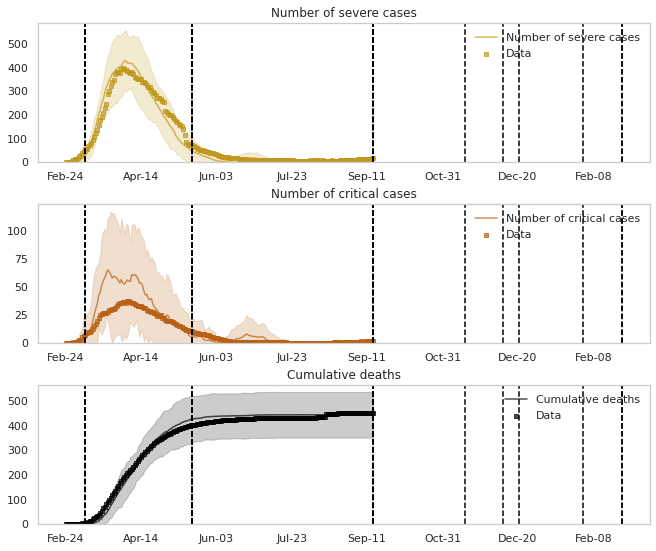

In [7]:
initial_params = {k[5:]: v for k, v in best_params.items() if k.startswith('init_')}
initial_params.update(default_params)

intervention_params = {k[7:]: v for k, v in best_params.items() if k.startswith('interv_')}
interventions = get_interventions(intervention_params)

sim = cv.Sim(pars=initial_params, interventions=interventions, datafile=df)
msim = cv.MultiSim(sim)
msim.run(n_runs=30)

msim.mean()
msim.plot(cols);

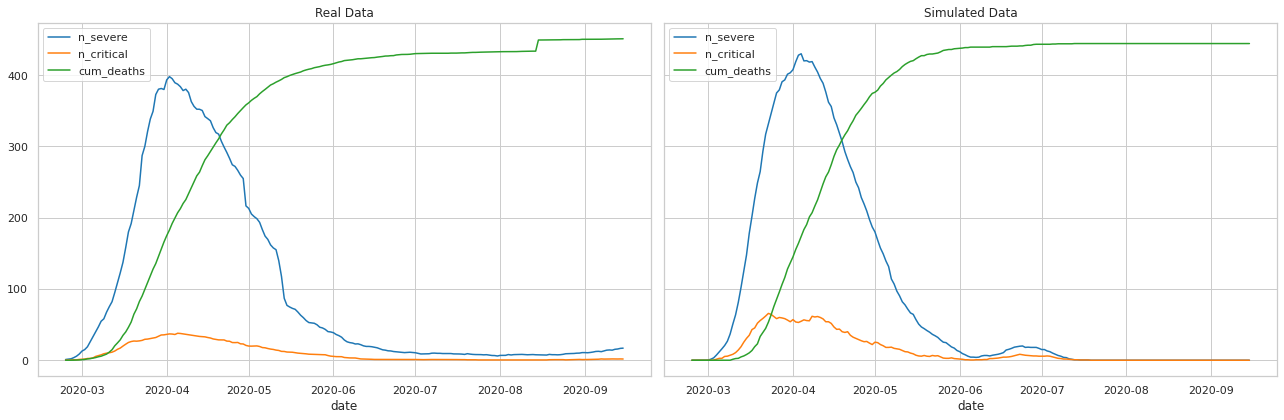

In [8]:
_, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=True)

for col in cols:
    sns.lineplot(data=df, x='date', y=col, label=col, ax=axes[0]).set(title='Real Data', ylabel='')
    sns.lineplot(data=msim.results, x='date', y=col, label=col, ax=axes[1]).set(title='Simulated Data', ylabel='')

plt.tight_layout()